In [44]:
import json
import pandas as pd
import pytz
import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# import aqi
from purpleair.network import SensorList
import time
from datetime import date
from purpleair.sensor import Sensor
import functions as func
import concurrent.futures
import pyecharts.options as opts
from pyecharts.charts import Calendar
import h5netcdf
import warnings
warnings.filterwarnings('ignore')

# Data acquisition, cleaning, organization

## Sensor from UIUC (AQMesh)

In [28]:
with open('Data/uiuc_sensor_till11302021.txt') as f:
    lines = f.readlines()

In [29]:
df_gases = pd.DataFrame()
df_particles = pd.DataFrame()
tot_gases =[]
tot_particles =[]

In [30]:
lines_count = len(lines)
print(lines_count)

3450


The text file has 3 repitive json strings. First is the sensor recording meta data which we wont use. Second json includes gas sensor readings and third one is particulate matter sensor data.

In [31]:
gas=1
particle=2
for i in range (0,int(lines_count/3)):
    gases=lines[gas]
    particles=lines[particle]
    res_gas = json.loads(gases)
    df_gas_1hr=pd.DataFrame(res_gas)
    df_gases=pd.concat([df_gases,df_gas_1hr])
    res_part = json.loads(particles)
    df_part_1hr=pd.DataFrame(res_part)
    df_particles=pd.concat([df_particles,df_part_1hr])
    gas=gas+3
    particle=particle+3

In [32]:
df_gases.head(10)

,gas_reading_number,location_number,pod_serial_number,owner_number,reading_datestamp,gas_p1,gas_p2,gas_p3,gasprotocol_version,battery_voltage,...,aux1_units,aux2_sensor_serial_number,aux2_type,aux2_state,aux2_prescaled,aux2_slope,aux2_offset,aux2_units,aux3,aux4
0,314226360,2356,2450738,440,2021-10-13T21:15:00,10,900,3600,V5.3,3.3,...,None,None,Not Fitted,Not Fitted,-1000.0,None,None,None,308.0,1225.0
1,314226361,2356,2450738,440,2021-10-13T21:30:00,10,900,3600,V5.3,3.3,...,None,None,Not Fitted,Not Fitted,-1000.0,None,None,None,304.0,1226.0
2,314226362,2356,2450738,440,2021-10-13T21:45:00,10,900,3600,V5.3,3.3,...,None,None,Not Fitted,Not Fitted,-1000.0,None,None,None,312.0,1226.0
3,314226363,2356,2450738,440,2021-10-13T22:00:00,10,900,3600,V5.3,3.3,...,None,None,Not Fitted,Not Fitted,-1000.0,None,None,None,303.0,1226.0
0,314233797,2356,2450738,440,2021-10-13T22:15:00,10,900,3600,V5.3,3.3,...,None,None,Not Fitted,Not Fitted,-1000.0,None,None,None,303.0,1225.0
1,314233798,2356,2450738,440,2021-10-13T22:30:00,10,900,3600,V5.3,3.3,...,None,None,Not Fitted,Not Fitted,-1000.0,None,None,None,302.0,1226.0
2,314233799,2356,2450738,440,2021-10-13T22:45:00,10,900,3600,V5.3,3.3,...,None,None,Not Fitted,Not Fitted,-1000.0,None,None,None,310.0,1226.0
3,314233800,2356,2450738,440,2021-10-13T23:00:00,10,900,3600,V5.3,3.3,...,None,None,Not Fitted,Not Fitted,-1000.0,None,None,None,318.0,1226.0
0,314241126,2356,2450738,440,2021-10-13T23:15:00,10,900,3600,V5.3,3.2,...,None,None,Not Fitted,Not Fitted,-1000.0,None,None,None,325.0,1226.0
1,314241127,2356,2450738,440,2021-10-13T23:30:00,10,900,3600,V5.3,3.2,...,None,None,Not Fitted,Not Fitted,-1000.0,None,None,None,330.0,1226.0


In [33]:
list(df_particles.columns)

['particle_reading_number',
 'location_number',
 'pod_serial_number',
 'owner_number',
 'reading_datestamp',
 'particle_p1',
 'particle_p2',
 'particle_p3',
 'particleprotocol_version',
 'reading_status',
 'battery_voltage',
 'battery_low',
 'super_cap_voltage',
 'temperature_f',
 'humidity',
 'pressure',
 'particle_modem_overlap',
 'pm10_prescale',
 'pm10_slope',
 'pm10_offset',
 'pm4_prescale',
 'pm4_slope',
 'pm4_offset',
 'pm2_5_prescale',
 'pm2_5_slope',
 'pm2_5_offset',
 'pm1_prescale',
 'pm1_slope',
 'pm1_offset',
 'pm_tpc_prescale',
 'pm_tpc_slope',
 'pm_tpc_offset',
 'pm_total_prescale',
 'pm_total_slope',
 'pm_total_offset']

In [34]:
desired_gas=['reading_datestamp','co_prescaled', 'no_prescaled','no2_prescaled','o3_prescaled','uart_prescaled', 'temperature_f',
 'pressure', 'humidity']

desired_particle=['reading_datestamp','pm1_prescale','pm2_5_prescale','pm4_prescale','pm10_prescale','pm_tpc_prescale','pm_total_prescale']

In [35]:
df_particles_select=df_particles[desired_particle]
df_particles_select

,reading_datestamp,pm1_prescale,pm2_5_prescale,pm4_prescale,pm10_prescale,pm_tpc_prescale,pm_total_prescale
0,2021-10-13T21:15:00,7.07,8.99,10.61,13.52,3.77,13.52
1,2021-10-13T21:30:00,6.87,8.72,10.11,12.10,3.69,12.10
2,2021-10-13T21:45:00,7.01,8.54,9.69,11.42,3.72,11.42
3,2021-10-13T22:00:00,7.49,9.11,10.53,13.10,3.96,13.10
0,2021-10-13T22:15:00,7.05,8.66,9.98,12.00,3.76,12.00
...,...,...,...,...,...,...,...
3,2021-11-30T20:00:00,3.20,4.52,5.50,9.11,1.83,9.11
0,2021-11-30T20:15:00,3.21,4.38,5.31,9.70,1.81,9.72
1,2021-11-30T20:30:00,3.20,4.41,5.38,9.14,1.82,9.14
2,2021-11-30T20:45:00,3.15,4.51,5.44,8.46,1.79,8.46


In [36]:
df_gases_select=df_gases[desired_gas]
df_gases_select['uart_prescaled']=df_gases_select.uart_prescaled-350
df_gases_select

<ipython-input-36-896b593504e8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gases_select['uart_prescaled']=df_gases_select.uart_prescaled-350


,reading_datestamp,co_prescaled,no_prescaled,no2_prescaled,o3_prescaled,uart_prescaled,temperature_f,pressure,humidity
0,2021-10-13T21:15:00,349.51,7.33,24.83,38.56,440.46,70.0,985.3,83.0
1,2021-10-13T21:30:00,337.36,8.70,20.90,37.08,438.77,70.3,984.6,82.5
2,2021-10-13T21:45:00,331.62,9.72,21.68,34.38,438.77,70.5,984.1,82.2
3,2021-10-13T22:00:00,335.03,7.95,22.65,33.82,441.33,70.5,983.8,82.5
0,2021-10-13T22:15:00,333.17,12.76,20.34,31.10,440.46,70.5,983.7,82.8
...,...,...,...,...,...,...,...,...,...
3,2021-11-30T20:00:00,300.71,3.34,5.50,30.32,426.00,54.3,992.7,58.5
0,2021-11-30T20:15:00,303.22,2.44,5.20,29.64,425.16,54.1,992.9,58.8
1,2021-11-30T20:30:00,313.67,3.17,5.35,29.84,426.00,54.0,992.9,58.8
2,2021-11-30T20:45:00,309.89,5.20,4.53,33.18,426.85,53.6,992.9,58.8


In [37]:
merged= pd.merge(df_gases_select,df_particles_select, on='reading_datestamp')

In [38]:
merged['nox_prescaled'] = merged.no_prescaled + merged.no2_prescaled
merged = merged.rename({'uart_prescaled': 'CO2_prescaled'}, axis=1)
merged

,reading_datestamp,co_prescaled,no_prescaled,no2_prescaled,o3_prescaled,CO2_prescaled,temperature_f,pressure,humidity,pm1_prescale,pm2_5_prescale,pm4_prescale,pm10_prescale,pm_tpc_prescale,pm_total_prescale,nox_prescaled
0,2021-10-13T21:15:00,349.51,7.33,24.83,38.56,440.46,70.0,985.3,83.0,7.07,8.99,10.61,13.52,3.77,13.52,32.16
1,2021-10-13T21:30:00,337.36,8.70,20.90,37.08,438.77,70.3,984.6,82.5,6.87,8.72,10.11,12.10,3.69,12.10,29.60
2,2021-10-13T21:45:00,331.62,9.72,21.68,34.38,438.77,70.5,984.1,82.2,7.01,8.54,9.69,11.42,3.72,11.42,31.40
3,2021-10-13T22:00:00,335.03,7.95,22.65,33.82,441.33,70.5,983.8,82.5,7.49,9.11,10.53,13.10,3.96,13.10,30.60
4,2021-10-13T22:15:00,333.17,12.76,20.34,31.10,440.46,70.5,983.7,82.8,7.05,8.66,9.98,12.00,3.76,12.00,33.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4615,2021-11-30T20:00:00,300.71,3.34,5.50,30.32,426.00,54.3,992.7,58.5,3.20,4.52,5.50,9.11,1.83,9.11,8.84
4616,2021-11-30T20:15:00,303.22,2.44,5.20,29.64,425.16,54.1,992.9,58.8,3.21,4.38,5.31,9.70,1.81,9.72,7.64
4617,2021-11-30T20:30:00,313.67,3.17,5.35,29.84,426.00,54.0,992.9,58.8,3.20,4.41,5.38,9.14,1.82,9.14,8.52
4618,2021-11-30T20:45:00,309.89,5.20,4.53,33.18,426.85,53.6,992.9,58.8,3.15,4.51,5.44,8.46,1.79,8.46,9.73


In [39]:
df = merged.drop_duplicates('reading_datestamp', keep='first')
df

,reading_datestamp,co_prescaled,no_prescaled,no2_prescaled,o3_prescaled,CO2_prescaled,temperature_f,pressure,humidity,pm1_prescale,pm2_5_prescale,pm4_prescale,pm10_prescale,pm_tpc_prescale,pm_total_prescale,nox_prescaled
0,2021-10-13T21:15:00,349.51,7.33,24.83,38.56,440.46,70.0,985.3,83.0,7.07,8.99,10.61,13.52,3.77,13.52,32.16
1,2021-10-13T21:30:00,337.36,8.70,20.90,37.08,438.77,70.3,984.6,82.5,6.87,8.72,10.11,12.10,3.69,12.10,29.60
2,2021-10-13T21:45:00,331.62,9.72,21.68,34.38,438.77,70.5,984.1,82.2,7.01,8.54,9.69,11.42,3.72,11.42,31.40
3,2021-10-13T22:00:00,335.03,7.95,22.65,33.82,441.33,70.5,983.8,82.5,7.49,9.11,10.53,13.10,3.96,13.10,30.60
4,2021-10-13T22:15:00,333.17,12.76,20.34,31.10,440.46,70.5,983.7,82.8,7.05,8.66,9.98,12.00,3.76,12.00,33.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4615,2021-11-30T20:00:00,300.71,3.34,5.50,30.32,426.00,54.3,992.7,58.5,3.20,4.52,5.50,9.11,1.83,9.11,8.84
4616,2021-11-30T20:15:00,303.22,2.44,5.20,29.64,425.16,54.1,992.9,58.8,3.21,4.38,5.31,9.70,1.81,9.72,7.64
4617,2021-11-30T20:30:00,313.67,3.17,5.35,29.84,426.00,54.0,992.9,58.8,3.20,4.41,5.38,9.14,1.82,9.14,8.52
4618,2021-11-30T20:45:00,309.89,5.20,4.53,33.18,426.85,53.6,992.9,58.8,3.15,4.51,5.44,8.46,1.79,8.46,9.73


In [41]:
old_data= pd.read_csv('Data/old_data_uiuc.csv', sep=',',parse_dates=['reading_datestamp'],infer_datetime_format=True)

In [42]:
df = pd.concat([old_data,df])
df

,reading_datestamp,co_prescaled,CO2_prescaled,no_prescaled,no2_prescaled,o3_prescaled,pm1_prescale,pm2_5_prescale,pm4_prescale,pm10_prescale,pm_total_prescale,pm_tpc_prescale,nox_prescaled,temperature_f,pressure,humidity
0,2021-09-02 09:45:00,250.38,420.35,15.87,6.86,14.86,5.38,6.94,8.00,10.23,10.23,2.91,13.14,75.9,992.6,63.6
1,2021-09-02 10:00:00,255.19,418.04,15.78,7.10,16.61,5.26,6.89,7.97,9.76,9.76,2.82,12.58,77.0,992.5,62.5
2,2021-09-02 10:15:00,254.69,413.88,15.90,7.30,18.42,5.35,6.98,8.12,11.68,11.70,2.88,14.58,77.7,993.0,61.5
3,2021-09-02 10:30:00,265.17,412.49,15.54,7.48,20.59,5.20,6.77,7.84,9.82,9.82,2.78,12.60,78.4,992.3,61.0
4,2021-09-02 10:45:00,256.95,408.79,17.10,6.56,23.36,5.40,6.97,8.12,10.32,10.32,2.92,13.24,79.2,992.9,59.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4615,2021-11-30T20:00:00,300.71,426.00,3.34,5.50,30.32,3.20,4.52,5.50,9.11,9.11,1.83,8.84,54.3,992.7,58.5
4616,2021-11-30T20:15:00,303.22,425.16,2.44,5.20,29.64,3.21,4.38,5.31,9.70,9.72,1.81,7.64,54.1,992.9,58.8
4617,2021-11-30T20:30:00,313.67,426.00,3.17,5.35,29.84,3.20,4.41,5.38,9.14,9.14,1.82,8.52,54.0,992.9,58.8
4618,2021-11-30T20:45:00,309.89,426.85,5.20,4.53,33.18,3.15,4.51,5.44,8.46,8.46,1.79,9.73,53.6,992.9,58.8


### Convert from UTC to Central Time (US)

In [43]:
df.set_index(pd.DatetimeIndex(df['reading_datestamp']), drop=False, inplace=True)
df.index = df.index.tz_localize('UTC')
df.index = df.index.tz_convert('US/Central')
df.index=df.index.strftime("%Y-%m-%d %H:%M:%S")
df=df.drop(['reading_datestamp'], axis=1)
df=df.reset_index()
df

,reading_datestamp,co_prescaled,CO2_prescaled,no_prescaled,no2_prescaled,o3_prescaled,pm1_prescale,pm2_5_prescale,pm4_prescale,pm10_prescale,pm_total_prescale,pm_tpc_prescale,nox_prescaled,temperature_f,pressure,humidity
0,2021-09-02 04:45:00,250.38,420.35,15.87,6.86,14.86,5.38,6.94,8.00,10.23,10.23,2.91,13.14,75.9,992.6,63.6
1,2021-09-02 05:00:00,255.19,418.04,15.78,7.10,16.61,5.26,6.89,7.97,9.76,9.76,2.82,12.58,77.0,992.5,62.5
2,2021-09-02 05:15:00,254.69,413.88,15.90,7.30,18.42,5.35,6.98,8.12,11.68,11.70,2.88,14.58,77.7,993.0,61.5
3,2021-09-02 05:30:00,265.17,412.49,15.54,7.48,20.59,5.20,6.77,7.84,9.82,9.82,2.78,12.60,78.4,992.3,61.0
4,2021-09-02 05:45:00,256.95,408.79,17.10,6.56,23.36,5.40,6.97,8.12,10.32,10.32,2.92,13.24,79.2,992.9,59.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8540,2021-11-30 14:00:00,300.71,426.00,3.34,5.50,30.32,3.20,4.52,5.50,9.11,9.11,1.83,8.84,54.3,992.7,58.5
8541,2021-11-30 14:15:00,303.22,425.16,2.44,5.20,29.64,3.21,4.38,5.31,9.70,9.72,1.81,7.64,54.1,992.9,58.8
8542,2021-11-30 14:30:00,313.67,426.00,3.17,5.35,29.84,3.20,4.41,5.38,9.14,9.14,1.82,8.52,54.0,992.9,58.8
8543,2021-11-30 14:45:00,309.89,426.85,5.20,4.53,33.18,3.15,4.51,5.44,8.46,8.46,1.79,9.73,53.6,992.9,58.8


In [44]:
#Export in feather file format - More efficient
df2 = df.reset_index()
df2.to_feather('Data/export_UIUC_feather')

## Sensors from purple air

In [65]:
sensor = Sensor(10894, parse_location=True)
df_sensor = sensor.parent.get_historical(weeks_to_get= 14, start_date = date(2021, 12, 7),
                              thingspeak_field='primary')

In [66]:
df_sensor.created_at = pd.DatetimeIndex(df_sensor.created_at).tz_convert('US/Central')
df_sensor['created_at'] = df_sensor['created_at'].dt.strftime('%Y-%m-%d %H:%M:%S').tolist()
df_sensor

,created_at,PM1.0 (CF=1) ug/m3,PM2.5 (CF=1) ug/m3,PM10.0 (CF=1) ug/m3,UptimeMinutes,ADC,Temperature_F,Humidity_%,PM2.5 (CF=ATM) ug/m3
entry_id,,,,,,,,,
978053,2021-11-29 18:01:19,2.00,3.57,3.73,18121.0,-68.0,47.0,38.0,3.57
978054,2021-11-29 18:03:19,2.10,3.81,4.66,18123.0,-66.0,47.0,38.0,3.81
978055,2021-11-29 18:05:19,2.31,3.81,3.81,18125.0,-66.0,47.0,38.0,3.81
978056,2021-11-29 18:07:19,2.36,4.11,4.18,18127.0,-67.0,47.0,39.0,4.11
978057,2021-11-29 18:09:19,1.40,2.96,3.70,18129.0,-66.0,47.0,39.0,2.96
...,...,...,...,...,...,...,...,...,...
931261,2021-08-30 17:36:56,5.02,7.78,8.00,8651.0,-61.0,87.0,51.0,7.78
931262,2021-08-30 17:38:56,5.14,6.71,6.71,8653.0,-61.0,87.0,51.0,6.71
931263,2021-08-30 17:40:56,4.70,6.34,6.34,8655.0,-61.0,87.0,51.0,6.34


In [ ]:
p = SensorList()  # Initialized 11,220 sensors!
# Other sensor filters include 'outside', 'useful', 'family', and 'no_child'
df = p.to_dataframe(sensor_filter='all',
                    channel='parent')
# df[df['id'] == 10894]
df[df.index == 10894]['name'].values[0]

Warnow-Chacko(South-west): 10894
Urbana(South-east):94415
Urbana on Holmes:107592

In [68]:
WarnowChacko = Sensor(10894, parse_location=True)
print(type(WarnowChacko))
Urbana = Sensor(94415, parse_location=True)
print(Urbana)
UrbanaOnHolmes = Sensor(107592, parse_location=True)
print(UrbanaOnHolmes)

<class 'purpleair.sensor.Sensor'>
Sensor 94415 at 1559, South Vine Street, West Urbana, Urbana, Champaign County, Illinois, 61801, United States
Sensor 107592 at 345, East Holmes Street, Urbana, Champaign County, Illinois, 61801, United States


In [ ]:
df_WarnowChacko = func.get_sensor_data(10894)

In [ ]:
df_Urbana = func.get_sensor_data(94415)

In [ ]:
df_UrbanaOnHolmes = func.get_sensor_data(107592)

In [ ]:
df_WarnowChacko.to_feather('Data/export_WarnowChacko_feather')
df_Urbana.to_feather('Data/export_Urbana_feather')
df_UrbanaOnHolmes.to_feather('Data/export_UrbanaOnHolmes_feather')

## Use api and multi-threads to get the combaination from purple air

In [ ]:
sensor_list = [10894, 94415, 107592]
columns = ['new_date', 'PM1.0 (CF=1) ug/m3', 'PM2.5 (CF=1) ug/m3', 'PM10.0 (CF=1) ug/m3',
          'UptimeMinutes', 'ADC', 'Temperature_F', 'Humidity_%', 'PM2.5 (CF=ATM) ug/m3', 'sensor_name']
df_sensor = pd.DataFrame(columns = columns)
fs = []
executor = concurrent.futures.ThreadPoolExecutor(max_workers=len(sensor_list))
for i in sensor_list:
    f = executor.submit(sf.get_sensor_data, i)
    fs.append(f)

df_list = []
    
for f in fs:
    df_sensor = df_sensor.append(f.result())

executor.shutdown()
df_sensor.reset_index(drop = True)
df_UIUC = pd.read_feather('export_UIUC_feather', columns=None, use_threads=True)
df_UIUC = df_UIUC.drop(['index'], axis = 1)
df_UIUC.rename(columns={'reading_datestamp': 'new_date'}, inplace = True)
final_df = df_UIUC.merge(df_sensor, on='new_date')
final_df = final_df.drop_duplicates().reset_index().drop(['index'], axis = 1)
final_df = final_df[columns]
df_UIUC = pd.read_feather('export_UIUC_feather', columns=None, use_threads=True)
df_UIUC = df_UIUC.drop(['index'], axis = 1)
df_UIUC['sensor_name'] = 'UIUC'
df_UIUC.rename(columns={'reading_datestamp': 'new_date'}, inplace = True)
df_UIUC.rename(columns={'pm2_5_prescale': 'PM2.5 (CF=1) ug/m3'}, inplace = True)
final_df = final_df.append(df_UIUC)[columns].reset_index(drop = True)
final_df['new_date']=pd.to_datetime(final_df['new_date'],format='%Y-%m-%d %H:%M:%S')
final_df['date'] = pd.to_datetime(final_df['new_date'],format='%Y-%m-%d %H:%M:%S').dt.date
final_df['time'] = pd.to_datetime(final_df['new_date'],format='%Y-%m-%d %H:%M:%S').dt.time
final_df['dayofweek'] = pd.to_datetime(final_df['new_date'],format='%Y-%m-%d %H:%M:%S').dt.dayofweek

# Read the data

In [43]:
# Read feather file
df_UIUC = pd.read_feather('Data/export_UIUC_feather', columns=None, use_threads=True)
df_UIUC = df_UIUC.drop(['index'], axis=1)
# Now we will import the data acquired and cleaned from PurpleAir.com for 3 locations and merge with our dataset.
# a
df_UrbanaOnHolmes = pd.read_feather('Data/export_UrbanaOnHolmes_feather', columns=None, use_threads=True)
df_Urbana = pd.read_feather('Data/export_Urbana_feather', columns=None, use_threads=True)
df_Champaign = pd.read_feather('Data/export_WarnowChacko_feather', columns=None, use_threads=True)

# Data Visualization

## Hypothesis1 - PM2.5 represents the ambient air quality.

In [46]:
# Read feather file
df = pd.read_feather('Data/export_UIUC_feather', columns=None, use_threads=True)
df=df.drop(['index'], axis=1)
df

,reading_datestamp,co_prescaled,CO2_prescaled,no_prescaled,no2_prescaled,o3_prescaled,pm1_prescale,pm2_5_prescale,pm4_prescale,pm10_prescale,pm_total_prescale,pm_tpc_prescale,nox_prescaled,temperature_f,pressure,humidity
0,2021-09-02 04:45:00,250.38,420.35,15.87,6.86,14.86,5.38,6.94,8.00,10.23,10.23,2.91,13.14,75.9,992.6,63.6
1,2021-09-02 05:00:00,255.19,418.04,15.78,7.10,16.61,5.26,6.89,7.97,9.76,9.76,2.82,12.58,77.0,992.5,62.5
2,2021-09-02 05:15:00,254.69,413.88,15.90,7.30,18.42,5.35,6.98,8.12,11.68,11.70,2.88,14.58,77.7,993.0,61.5
3,2021-09-02 05:30:00,265.17,412.49,15.54,7.48,20.59,5.20,6.77,7.84,9.82,9.82,2.78,12.60,78.4,992.3,61.0
4,2021-09-02 05:45:00,256.95,408.79,17.10,6.56,23.36,5.40,6.97,8.12,10.32,10.32,2.92,13.24,79.2,992.9,59.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8540,2021-11-30 14:00:00,300.71,426.00,3.34,5.50,30.32,3.20,4.52,5.50,9.11,9.11,1.83,8.84,54.3,992.7,58.5
8541,2021-11-30 14:15:00,303.22,425.16,2.44,5.20,29.64,3.21,4.38,5.31,9.70,9.72,1.81,7.64,54.1,992.9,58.8
8542,2021-11-30 14:30:00,313.67,426.00,3.17,5.35,29.84,3.20,4.41,5.38,9.14,9.14,1.82,8.52,54.0,992.9,58.8
8543,2021-11-30 14:45:00,309.89,426.85,5.20,4.53,33.18,3.15,4.51,5.44,8.46,8.46,1.79,9.73,53.6,992.9,58.8


In [48]:
df['reading_datestamp'] = pd.to_datetime(df['reading_datestamp'])
# set a column as the index
df.set_index('reading_datestamp', inplace=True)
df.head()

,co_prescaled,CO2_prescaled,no_prescaled,no2_prescaled,o3_prescaled,pm1_prescale,pm2_5_prescale,pm4_prescale,pm10_prescale,pm_total_prescale,pm_tpc_prescale,nox_prescaled,temperature_f,pressure,humidity
reading_datestamp,,,,,,,,,,,,,,,
2021-09-02 04:45:00,250.38,420.35,15.87,6.86,14.86,5.38,6.94,8.00,10.23,10.23,2.91,13.14,75.9,992.6,63.6
2021-09-02 05:00:00,255.19,418.04,15.78,7.10,16.61,5.26,6.89,7.97,9.76,9.76,2.82,12.58,77.0,992.5,62.5
2021-09-02 05:15:00,254.69,413.88,15.90,7.30,18.42,5.35,6.98,8.12,11.68,11.70,2.88,14.58,77.7,993.0,61.5
2021-09-02 05:30:00,265.17,412.49,15.54,7.48,20.59,5.20,6.77,7.84,9.82,9.82,2.78,12.60,78.4,992.3,61.0
2021-09-02 05:45:00,256.95,408.79,17.10,6.56,23.36,5.40,6.97,8.12,10.32,10.32,2.92,13.24,79.2,992.9,59.8


(18872.0, 18959.0)

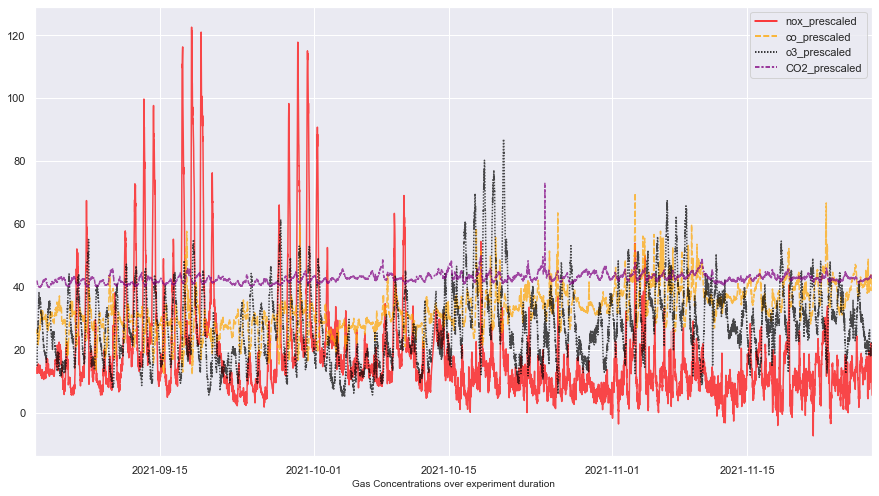

In [51]:
from datetime import datetime as dt
df_scale=df.copy()
df_scale['co_prescaled']=df_scale['co_prescaled']/10
df_scale['CO2_prescaled']=df_scale['CO2_prescaled']/10
sns.set_context("notebook", font_scale=1)
sns.set(rc={'figure.figsize':(15,8.27)})
left = dt(2021,9,2)
right = dt(2021,11,28)
ax = sns.lineplot(data=df_scale[['nox_prescaled', 'co_prescaled', 'o3_prescaled','CO2_prescaled']], palette = ['red', 'orange','black','purple'], alpha=0.7)
ax.set_xlabel('Gas Concentrations over experiment duration', fontsize=10)
ax.set_xlim(left, right)

In [ ]:
# Now we will import the data acquired and cleaned from PurpleAir.com for 3 locations and merge with our dataset.
df_urbanaOH = df_UrbanaOnHolmes.copy()
df_urbanaOH['new_date'] = pd.to_datetime(df_urbanaOH['new_date'])
df_urbanaOH=df_urbanaOH[['new_date','PM2.5 (CF=1) ug/m3']]
df_urbanaOH = df_urbanaOH.rename({'new_date': 'reading_datestamp','PM2.5 (CF=1) ug/m3': 'pm2.5_UrbanaOH' }, axis=1)
df_urbanaOH.set_index('reading_datestamp', inplace=True)
#df_urbanaOH
df_urbanaOH = df_urbanaOH[df_urbanaOH.index.isin(df.index)]

df_urbana = df_Urbana.copy()
df_urbana['new_date'] = pd.to_datetime(df_urbana['new_date'])
df_urbana=df_urbana[['new_date','PM2.5 (CF=1) ug/m3']]
df_urbana = df_urbana.rename({'new_date': 'reading_datestamp','PM2.5 (CF=1) ug/m3': 'pm2.5_Urbana' }, axis=1)
df_urbana.set_index('reading_datestamp', inplace=True)
# df_urbana
df_urbana = df_urbana[df_urbana.index.isin(df.index)]

df_champaign = df_Champaign.copy()
df_champaign['new_date'] = pd.to_datetime(df_champaign['new_date'])
df_champaign=df_champaign[['new_date','PM2.5 (CF=1) ug/m3']]
df_champaign = df_champaign.rename({'new_date': 'reading_datestamp','PM2.5 (CF=1) ug/m3': 'pm2.5_Champaign' }, axis=1)
df_champaign.set_index('reading_datestamp', inplace=True)
# df_champaign
df_champaign = df_champaign[df_champaign.index.isin(df.index)]
#Since the location in Champaign has data missing for some days we will keep it seperate for now.

combined_urbana= pd.merge(df_urbanaOH,df_urbana, on='reading_datestamp')
merged= pd.merge(df,combined_urbana, on='reading_datestamp')
merged.info() # This is the data for UIUC + 2 purple air locations in Urbana
df_champaign.info()

### Converting concentrations to AIR Quality Index

To get AQI values from PM2.5 we will directly convert the PM2.5 concentrations to AQI using U.S EPA algorithm.

In [ ]:
df_aqi = merged.copy()
from functions import val_to_aqi
df_aqi['AQI_UIUC_PM25']=val_to_aqi('POLLUTANT_PM25', df_aqi['pm2_5_prescale']) #based on pm2.5 vals from UIUC sensor
df_aqi['AQI_UrbanaOH']=val_to_aqi('POLLUTANT_PM25', df_aqi['pm2.5_UrbanaOH'])
df_aqi['AQI_Urbana']=val_to_aqi('POLLUTANT_PM25', df_aqi['pm2.5_Urbana'])
df_aqi_25= df_aqi[['AQI_UrbanaOH','AQI_Urbana','AQI_UIUC_PM25']].copy()
df_aqi_25

In [ ]:
from functions import combined_aqi

df_aqi = merged[['co_prescaled','no2_prescaled','o3_prescaled','pm10_prescale','pm2_5_prescale']].copy()
df_aqi= df_aqi.dropna()
df_aqi.reset_index(level=0, inplace=True)
df_aqi['co_prescaled']= df_aqi['co_prescaled']/1000
df_aqi['o3_prescaled']=df_aqi['o3_prescaled']/1000

for i in df_aqi.index.values.tolist():
    df_aqi.loc[i,'combAQI'] = combined_aqi(df_aqi.iloc[i].tolist())

df_aqi.set_index('reading_datestamp', inplace=True)
df_aqi_uiuc=df_aqi[['combAQI']].copy()
df_aqi_uiuc

In [ ]:
AQI_combined= pd.merge(df_aqi_uiuc,df_aqi_25, on='reading_datestamp')
#AQI_combined.reset_index(level=0, inplace=True)
AQI_combined

In [ ]:
# Now let us combine all 3 purple air AQI values with AQI from UIUC sensor PM2.5 only and PM + gases combined
df_champaign_AQI = pd.DataFrame()
df_champaign_AQI['reading_datestamp'] = df_champaign.index

df_champaign_AQI['AQI_Champaign']=val_to_aqi('POLLUTANT_PM25', df_champaign['pm2.5_Champaign'])

df_champaign_AQI=df_champaign_AQI.iloc[0:6062]
# df_champaign_AQI

AQI_combined_all= pd.merge(AQI_combined,df_champaign_AQI,  how='inner', on='reading_datestamp')
AQI_combined_all.set_index('reading_datestamp', inplace=True)
AQI_combined_all

In [ ]:
sns.set_context("notebook", font_scale=1)
sns.set(rc={'figure.figsize':(15,8.27)})
left = datetime(2021,9,25)
right = datetime(2021,11,28)
ax = sns.lineplot(data=AQI_combined_all[['combAQI','AQI_UIUC_PM25', 'AQI_UrbanaOH','AQI_Urbana','AQI_Champaign']],
                  palette = ['red', 'blue','black','purple', 'cyan'], alpha=0.6)
#ax = sns.lineplot(data=df_champaign[['pm2.5_Champaign']], palette = ['brown'], alpha=0.6)
ax.set_xlabel('AQI Comparison - AQMesh vs Purple Air', fontsize=10)
ax.set_xlim(left, right)

### All values almost overlap eachother.

In [ ]:
from datetime import datetime as dt
import seaborn as sns
sns.set_context("notebook", font_scale=1,rc={'figure.figsize':(18,6)})
left = datetime(2021,9,25)
right = datetime(2021,11,28)
ax = sns.lineplot(data=merged[['pm2_5_prescale', 'pm2.5_UrbanaOH','pm2.5_Urbana']], palette = ['navy', 'black','purple'], alpha=0.6)
ax = sns.lineplot(data=df_champaign[['pm2.5_Champaign']], palette = ['brown'], alpha=0.6)
ax.set_xlabel('AQMesh vs Purple Air', fontsize=10)
ax.set_xlim(left, right)

In [ ]:
# Convert UIUC Sensor to AQI

df_aqi = merged[['co_prescaled','no2_prescaled','o3_prescaled','pm10_prescale','pm2_5_prescale']].copy()
df_aqi= df_aqi.dropna()
df_aqi.reset_index(level=0, inplace=True)
df_aqi['co_prescaled']= df_aqi['co_prescaled']/1000
df_aqi['o3_prescaled']=df_aqi['o3_prescaled']/1000

df_covertedAQI = pd.DataFrame()
df_covertedAQI['reading_datestamp']=df_aqi['reading_datestamp']
df_covertedAQI['AQI_CO']=val_to_aqi('POLLUTANT_CO_8H', df_aqi['co_prescaled'])
df_covertedAQI['AQI_NO2']=val_to_aqi('POLLUTANT_NO2_1H', df_aqi['no2_prescaled'])
df_covertedAQI['AQI_O3']=val_to_aqi('POLLUTANT_O3_8H', df_aqi['o3_prescaled'])
df_covertedAQI['AQI_PM10']=val_to_aqi('POLLUTANT_PM10', df_aqi['pm10_prescale'])
df_covertedAQI['AQI_PM25']=val_to_aqi('POLLUTANT_PM25', df_aqi['pm2_5_prescale'])
df_covertedAQI.set_index('reading_datestamp', inplace=True)
df_covertedAQI

In [ ]:
AQI_combined['combAQI_c']= [func.get_label(val) for val in AQI_combined['combAQI']]
AQI_combined['AQI_UIUC_PM25_c']= [func.get_label(val) for val in AQI_combined['AQI_UIUC_PM25']]
AQI_combined['AQI_UrbanaOH_c']= [func.get_label(val) for val in AQI_combined['AQI_UrbanaOH']]
AQI_combined['AQI_Urbana_c']= [func.get_label(val) for val in AQI_combined['AQI_Urbana']]
AQI_combined

In [ ]:
colz= AQI_combined.columns[4:]
for col in colz:
    Comparison[col]=AQI_combined[col].value_counts().to_frame()
Comparison

In [ ]:
colors = ['purple',  'red', 'orange', 'yellow', 'green']
orders = ['Very Unhealthy', 'Unhealthy', 'Unhealthy for Sensitive Groups', 'Moderate', 'Good']
colormap = dict(zip(orders, colors))
colormap

In [ ]:
sns.scatterplot(data=AQI_combined, x=AQI_combined.index.week, y=AQI_combined['AQI_Urbana'],
                hue='AQI_Urbana_c', palette=colormap, alpha=0.8)


In [ ]:
sns.scatterplot(data=AQI_combined, x=AQI_combined.index.week, y=AQI_combined['combAQI'],
                hue='combAQI_c', palette=colormap, alpha=0.8)

In [ ]:
sns.scatterplot(data=AQI_combined, x=AQI_combined.index.week, y=AQI_combined['AQI_UrbanaOH'],
                hue='AQI_UrbanaOH_c', palette=colormap, alpha=0.8)

In [ ]:
sns.set_context("notebook", font_scale=1)
sns.set(rc={'figure.figsize':(15,8.27)})
left = datetime(2021,10,1)
right = datetime(2021,10,10)
ax = sns.lineplot(data=AQI_combined_all[['combAQI', 'AQI_UrbanaOH','AQI_Urbana','AQI_Champaign']], palette = ['red', 'black','purple', 'yellow'], alpha=0.6)
#ax = sns.lineplot(data=df_champaign[['pm2.5_Champaign']], palette = ['brown'], alpha=0.6)
ax.set_xlabel('AQI Comparison - AQMesh vs Purple Air (10 Day) ', fontsize=10)
ax.set_xlim(left, right)

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(25,10))


axes[0].pie(AQI_combined.combAQI_c.value_counts(),
        labels= AQI_combined.combAQI_c.unique(),
        colors=['yellow', 'orange', 'red', 'green', 'purple'], autopct='%1.1f%%', pctdistance=1.2);
axes[1].pie(AQI_combined.AQI_UrbanaOH_c.value_counts(),
        labels= AQI_combined.AQI_UrbanaOH_c.unique(),
        colors=['yellow', 'orange', 'red', 'green', 'purple'], autopct='%1.1f%%', pctdistance=1.2);
axes[2].pie(AQI_combined.AQI_Urbana_c.value_counts(),
        labels= AQI_combined.AQI_Urbana_c.unique(),
        colors=['yellow', 'orange', 'red', 'green', 'purple'], autopct='%1.1f%%', pctdistance=1.2);
plt.title('AQI % for UIUC Sensor');
plt.title('AQI % for UIUC Sensor');

In [ ]:
#### Other stuff

In [ ]:
#Lets get daily values to plot
df4= merged.groupby(np.arange(len(merged))//96).mean()
df4

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
ax = plt.axes()

x = list(range(1, 91))
# ax.plot(x, df4['pm2_5_prescale'].tolist(), label="PM2.5")
ax.plot(x, df4['CO2_prescaled'].tolist(), label="CO2")
#ax.plot(x, df4['co_prescaled'].tolist(), label="CO")
# ax.plot(x, df4['no_prescaled'].tolist(), label="NO")
# ax.plot(x, df4['no2_prescaled'].tolist(), label="NO2")
# ax.plot(x, df4['o3_prescaled'].tolist(), label="Ozone")
# ax.plot(x, df4['temperature_f'].tolist(), label="Temp F")
#ax.plot(x, df4['pressure'].tolist(), label="Pressure")
ax.plot(x, df4['humidity'].tolist(), label="Humidity")
plt.xlabel("Days (1-90)")
#plt.ylabel("PM 2.5 Val in PPB")
plt.legend(title="Legend")

In [ ]:
df4= df3.groupby(np.arange(len(df3))//96).mean()
df4

## Hypothesis2 - The relationship between PM2.5 and time

Warnow-Chacko(South-west): 10894
Urbana(South-east):94415
Urbana on Holmes:107592

In [ ]:
sensor_list = [10894, 94415, 107592]
columns = ['new_date', 'PM1.0 (CF=1) ug/m3', 'PM2.5 (CF=1) ug/m3', 'PM10.0 (CF=1) ug/m3',
          'UptimeMinutes', 'ADC', 'Temperature_F', 'Humidity_%', 'PM2.5 (CF=ATM) ug/m3', 'sensor_name']
df_sensor = pd.DataFrame(columns = columns)

In [ ]:
df_sensor = df_Urbana.copy().append(df_Champaign.copy()).append(df_UrbanaOnHolmes.copy())
df_sensor.reset_index(drop = True)
df_UIUC1 = df_UIUC.copy()
df_UIUC1 = pd.read_feather('export_UIUC_feather', columns=None, use_threads=True)
df_UIUC1 = df_UIUC1.drop(['index'], axis = 1)
df_UIUC1.rename(columns={'reading_datestamp': 'new_date'}, inplace = True)
final_df = df_UIUC1.merge(df_sensor, on='new_date')
final_df = final_df.drop_duplicates().reset_index().drop(['index'], axis = 1)
final_df = final_df[columns]
df_UIUC1 = pd.read_feather('export_UIUC_feather', columns=None, use_threads=True)
df_UIUC1 = df_UIUC1.drop(['index'], axis = 1)
df_UIUC1['sensor_name'] = 'UIUC'
df_UIUC1.rename(columns={'reading_datestamp': 'new_date'}, inplace = True)
df_UIUC1.rename(columns={'pm2_5_prescale': 'PM2.5 (CF=1) ug/m3'}, inplace = True)
final_df = final_df.append(df_UIUC1)[columns].reset_index(drop = True)
final_df['new_date']=pd.to_datetime(final_df['new_date'],format='%Y-%m-%d %H:%M:%S')
final_df['date'] = pd.to_datetime(final_df['new_date'],format='%Y-%m-%d %H:%M:%S').dt.date
final_df['time'] = pd.to_datetime(final_df['new_date'],format='%Y-%m-%d %H:%M:%S').dt.time
final_df['dayofweek'] = pd.to_datetime(final_df['new_date'],format='%Y-%m-%d %H:%M:%S').dt.dayofweek

### Based On Time

In [ ]:
hour=final_df[['new_date', 'PM2.5 (CF=1) ug/m3', 'sensor_name','time']]

In [ ]:
def plot_part(sensor_name:str):
    df_hour= hour[hour['sensor_name']== sensor_name]
    df_hour_plot = df_hour.sort_values(by = ['time']).reset_index()
    df_mean = df_hour.groupby('time').agg('mean').reset_index()
    plt.figure(figsize=(20,5))
    chart = sns.stripplot(x='time',y='PM2.5 (CF=1) ug/m3',data=df_hour_plot)
    plt.ylabel('PM2.5', fontsize=15)
    plt.xlabel('Time Line', fontsize=15)
    for ind, label in enumerate(chart.get_xticklabels()):
        if ind % 10 == 0:  # every 10th label is kept
            label.set_visible(True)
        else:
            label.set_visible(False)
    plt.show()
    df_line = df_mean[['time', 'PM2.5 (CF=1) ug/m3']]
    df_line.plot(x = 'time', y = 'PM2.5 (CF=1) ug/m3', figsize = (15,10), title = 'TimeLine')

#### Urbana

In [ ]:
plot_part('Urbana')

#### Urbana on Holmes

In [ ]:
plot_part('Urbana on Holmes')

#### Warnow-Chacko

In [ ]:
plot_part('Warnow-Chacko')

#### UIUC

In [ ]:
plot_part('UIUC')

In [ ]:
df_temp1 = hour.groupby(['time', 'sensor_name']).agg('mean').reset_index()
df_temp1['time']=pd.to_datetime(df_temp1['time'],format='%H:%M:%S')
df_temp2 = df_temp1.pivot('time', 'sensor_name', 'PM2.5 (CF=1) ug/m3')
plt.figure(figsize=(20, 15))
sns.lineplot(data = df_temp2)

In [ ]:
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=False)
import cufflinks as cf

### Based on DayofWeek

In [ ]:
dayofweek=final_df[['new_date', 'PM2.5 (CF=1) ug/m3', 'sensor_name','dayofweek']]

In [ ]:
def dayofweek_polt(sensor_name: str):
    df_dayofweek = dayofweek[dayofweek['sensor_name']== sensor_name]
    plt.figure(figsize=(20,5))
    chart = sns.barplot(x='dayofweek',y='PM2.5 (CF=1) ug/m3',data=df_dayofweek)
    plt.xticks(chart.get_xticks(), ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
    plt.ylabel('Average PM2.5', fontsize=15)
    plt.xlabel('Day of Week', fontsize=15)
    print(chart)
    plt.figure(figsize=(10,5))
    sns.stripplot(x='dayofweek',y='PM2.5 (CF=1) ug/m3',data=df_dayofweek)
    plt.xticks(chart.get_xticks(), ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
    plt.ylabel('PM2.5', fontsize=15)
    plt.xlabel('Day of Week', fontsize=15)
    print(chart)
    plt.figure(figsize=(10,5))
    chart = sns.boxplot(x='dayofweek',y='PM2.5 (CF=1) ug/m3',data=df_dayofweek)
    plt.xticks(chart.get_xticks(), ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
    plt.ylabel('PM2.5', fontsize=15)
    plt.xlabel('Day of Week', fontsize=15)
    print(chart)

#### Urbana

In [ ]:
dayofweek_polt('Urbana')

#### Urbana on Holmes

In [ ]:
dayofweek_polt('Urbana on Holmes')

#### Warnow-Chacko

In [ ]:
dayofweek_polt('Warnow-Chacko')

#### UIUC

In [ ]:
dayofweek_polt('UIUC')

### Find the outliers

In [ ]:
df_quantile.dtypes
df_quantile['time'][0]

In [ ]:
df_quantile['Is_Time_Outlier'] = df_quantile.apply(lambda time: sf.is_time_outlier(df_quantile, time['time'],time['PM2.5 (CF=1) ug/m3']),axis=1)
df_quantile[df_quantile['Is_Time_Outlier']=='T']['date'].unique()
df_quantile

In [ ]:
df_quantile['Is_Dayofweek_Outlier'] = df_quantile.apply(lambda dayofweek: sf.is_date_outlier(df_quantile, dayofweek['dayofweek'],dayofweek['PM2.5 (CF=1) ug/m3']),axis=1)
df_quantile[df_quantile['Is_Dayofweek_Outlier']=='T']['date'].unique()

In [ ]:
df_outlier = df_quantile[(df_quantile['Is_Dayofweek_Outlier']=='T') & (df_quantile['Is_Time_Outlier']=='T')]
count = df_outlier.date.value_counts()
df_count = count.to_frame()
data = [
    [str(df_count.index[i]), int(df_count.date[i])]
    for i in range(df_count.size)
]


c = (
    Calendar(init_opts=opts.InitOpts())
    .add(
        series_name="",
        yaxis_data=data,
        calendar_opts=opts.CalendarOpts(
            pos_top="80",
            pos_left="30",
            pos_right="30",
            range_="2021",
        ),
    )
    .set_global_opts(
        title_opts=opts.TitleOpts(
            pos_top="10",
            pos_left="center",
            title="PM2.5 count heatmap"
        ),
        visualmap_opts=opts.VisualMapOpts(
            pos_top="230",
            max_=90, min_=1,
            orient="horizontal",
            is_piecewise=True, #
        ),
    )
)
c.render_notebook()

In [ ]:
df_notemp1 = df_quantile[df_quantile['Is_Time_Outlier'] == 'F'].groupby(['time', 'sensor_name']).agg('mean').reset_index()
df_notemp1['time']=pd.to_datetime(df_temp1['time'],format='%H:%M:%S')
df_notemp2 = df_temp1.pivot('time', 'sensor_name', 'PM2.5 (CF=1) ug/m3')
plt.figure(figsize=(15, 10))
sns.lineplot(data = df_notemp2)

In [ ]:
df_dayofweek_mean = df_quantile[(df_quantile['sensor_name']== 'UIUC') & (df_quantile['Is_Dayofweek_Outlier']== 'F')]
plt.figure(figsize=(20,5))
chart = sns.barplot(x='dayofweek',y='PM2.5 (CF=1) ug/m3',data=df_dayofweek_mean)
plt.xticks(chart.get_xticks(), ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.ylabel('Average PM2.5', fontsize=15)
plt.xlabel('Day of Week', fontsize=15)
print(chart)

In [ ]:
df_dayofweek_mean = df_quantile[(df_quantile['sensor_name']== 'Urbana') & (df_quantile['Is_Dayofweek_Outlier']== 'F')]
plt.figure(figsize=(20,5))
chart = sns.barplot(x='dayofweek',y='PM2.5 (CF=1) ug/m3',data=df_dayofweek_mean)
plt.xticks(chart.get_xticks(), ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.ylabel('Average PM2.5', fontsize=15)
plt.xlabel('Day of Week', fontsize=15)
print(chart)

# Hypothesis3 Relation between Pm2.5 and weather

In [2]:
df3 = pd.read_feather('Data/export_UIUC_feather', columns=None, use_threads=True)
df3 = df3.drop(['index'], axis = 1)
df4 = pd.read_feather('Data/export_Urbana_feather', columns=None, use_threads=True)
df5 = pd.read_feather('Data/export_UrbanaOnHolmes_feather', columns=None, use_threads=True)
df6 = pd.read_feather('Data/export_WarnowChacko_feather', columns=None, use_threads=True)

In [3]:
df3.rename(columns={'reading_datestamp': 'new_date'}, inplace = True)
df3.head(5)
df3['new_date'] = pd.to_datetime(df3['new_date'])
df3.set_index('new_date', inplace = True)
df3.head(5)


,co_prescaled,CO2_prescaled,no_prescaled,no2_prescaled,o3_prescaled,pm1_prescale,pm2_5_prescale,pm4_prescale,pm10_prescale,pm_total_prescale,pm_tpc_prescale,nox_prescaled,temperature_f,pressure,humidity
new_date,,,,,,,,,,,,,,,
2021-09-02 04:45:00,250.38,420.35,15.87,6.86,14.86,5.38,6.94,8.00,10.23,10.23,2.91,13.14,75.9,992.6,63.6
2021-09-02 05:00:00,255.19,418.04,15.78,7.10,16.61,5.26,6.89,7.97,9.76,9.76,2.82,12.58,77.0,992.5,62.5
2021-09-02 05:15:00,254.69,413.88,15.90,7.30,18.42,5.35,6.98,8.12,11.68,11.70,2.88,14.58,77.7,993.0,61.5
2021-09-02 05:30:00,265.17,412.49,15.54,7.48,20.59,5.20,6.77,7.84,9.82,9.82,2.78,12.60,78.4,992.3,61.0
2021-09-02 05:45:00,256.95,408.79,17.10,6.56,23.36,5.40,6.97,8.12,10.32,10.32,2.92,13.24,79.2,992.9,59.8


In [4]:
df4['new_date'] = pd.to_datetime(df4['new_date'])
df4 = df4[['new_date','PM2.5 (CF=1) ug/m3']]
df4.set_index('new_date', inplace = True)
df4 = df4[df4.index.isin(df3.index)]
df4.head(5)

,PM2.5 (CF=1) ug/m3
new_date,
2021-09-02 04:45:00,7.600000
2021-09-02 05:00:00,8.282857
2021-09-02 05:15:00,8.436250
2021-09-02 05:30:00,8.907143
2021-09-02 05:45:00,9.141250


In [5]:
df5['new_date'] = pd.to_datetime(df5['new_date'])
df5 = df5[['new_date','PM2.5 (CF=1) ug/m3']]
df5.set_index('new_date', inplace = True)
df5 = df5[df5.index.isin(df3.index)]
df5.head(5)

,PM2.5 (CF=1) ug/m3
new_date,
2021-09-02 04:45:00,8.567143
2021-09-02 05:00:00,9.157500
2021-09-02 05:15:00,9.065714
2021-09-02 05:30:00,9.797500
2021-09-02 05:45:00,9.164286


In [6]:
df6['new_date'] = pd.to_datetime(df6['new_date'])
df6 = df6[['new_date','PM2.5 (CF=1) ug/m3']]
df6.set_index('new_date', inplace = True)
df6 = df6[df6.index.isin(df3.index)]
df6.head(5)

,PM2.5 (CF=1) ug/m3
new_date,
2021-09-25 16:00:00,1.077500
2021-09-25 16:15:00,1.101429
2021-09-25 16:30:00,0.817500
2021-09-25 16:45:00,0.730000
2021-09-25 17:00:00,0.800000


In [7]:
temp_df = pd.merge(df4, df5, on = 'new_date')
temp_df.head(5)

,PM2.5 (CF=1) ug/m3_x,PM2.5 (CF=1) ug/m3_y
new_date,,
2021-09-02 04:45:00,7.600000,8.567143
2021-09-02 05:00:00,8.282857,9.157500
2021-09-02 05:15:00,8.436250,9.065714
2021-09-02 05:30:00,8.907143,9.797500
2021-09-02 05:45:00,9.141250,9.164286


</h6><b> Merging the sensor data </b></h6>

In [8]:
temp_dfnew = pd.merge(temp_df, df6, on = 'new_date')
temp_dfnew.head(5)

,PM2.5 (CF=1) ug/m3_x,PM2.5 (CF=1) ug/m3_y,PM2.5 (CF=1) ug/m3
new_date,,,
2021-09-25 16:00:00,0.944286,0.900000,1.077500
2021-09-25 16:15:00,0.945000,0.865714,1.101429
2021-09-25 16:30:00,0.838571,1.101250,0.817500
2021-09-25 16:45:00,0.825000,0.818571,0.730000
2021-09-25 17:00:00,0.760000,0.723750,0.800000


<h6><b> Merging data from Purple Air and UIUC Sensors </b></h6>

In [9]:
final_df = df3.merge(temp_dfnew, on='new_date')
final_df.head(5)

,co_prescaled,CO2_prescaled,no_prescaled,no2_prescaled,o3_prescaled,pm1_prescale,pm2_5_prescale,pm4_prescale,pm10_prescale,pm_total_prescale,pm_tpc_prescale,nox_prescaled,temperature_f,pressure,humidity,PM2.5 (CF=1) ug/m3_x,PM2.5 (CF=1) ug/m3_y,PM2.5 (CF=1) ug/m3
new_date,,,,,,,,,,,,,,,,,,
2021-09-25 16:00:00,301.88,412.95,0.26,5.27,28.23,1.63,2.85,3.91,7.90,7.90,1.06,5.53,62.1,989.9,48.7,0.944286,0.900000,1.077500
2021-09-25 16:15:00,305.64,411.10,0.22,5.06,27.92,1.51,2.81,4.03,7.82,7.82,1.02,5.28,61.2,990.1,49.5,0.945000,0.865714,1.101429
2021-09-25 16:30:00,305.33,411.10,0.26,4.66,28.77,1.27,2.27,3.23,6.23,6.23,0.85,4.92,60.6,990.5,49.8,0.838571,1.101250,0.817500
2021-09-25 16:45:00,293.65,409.71,-0.48,5.27,26.64,1.14,2.17,3.34,7.49,7.49,0.81,4.79,60.6,990.4,49.8,0.825000,0.818571,0.730000
2021-09-25 17:00:00,292.59,409.71,0.62,4.27,28.63,1.16,2.22,3.25,7.74,7.74,0.82,4.89,60.4,990.3,49.8,0.760000,0.723750,0.800000


</h6><b> Calculating the correlations </b></h6>

In [10]:
df3.corr()

,co_prescaled,CO2_prescaled,no_prescaled,no2_prescaled,o3_prescaled,pm1_prescale,pm2_5_prescale,pm4_prescale,pm10_prescale,pm_total_prescale,pm_tpc_prescale,nox_prescaled,temperature_f,pressure,humidity
co_prescaled,1.000000,0.490124,-0.529999,0.377341,0.006306,0.046460,0.054285,0.055805,0.057833,0.062758,0.050289,-0.351779,-0.779595,0.312841,0.235390
CO2_prescaled,0.490124,1.000000,-0.236228,0.107619,-0.397351,0.316632,0.322259,0.315345,0.271989,0.247572,0.326195,-0.177269,-0.402976,0.074233,0.638472
no_prescaled,-0.529999,-0.236228,1.000000,0.084578,0.014401,0.204724,0.157325,0.115316,0.085762,0.066059,0.190252,0.938455,0.637481,-0.096258,-0.250214
no2_prescaled,0.377341,0.107619,0.084578,1.000000,0.114406,0.081402,0.062384,0.044075,0.048378,0.046150,0.075433,0.419605,-0.065527,0.263359,-0.223919
o3_prescaled,0.006306,-0.397351,0.014401,0.114406,1.000000,-0.221654,-0.192928,-0.175131,-0.108317,-0.078156,-0.217065,0.051771,0.091613,0.126110,-0.682578
pm1_prescale,0.046460,0.316632,0.204724,0.081402,-0.221654,1.000000,0.943740,0.855074,0.718460,0.648200,0.993371,0.214391,0.238508,-0.094014,0.199738
pm2_5_prescale,0.054285,0.322259,0.157325,0.062384,-0.192928,0.943740,1.000000,0.977790,0.894604,0.836880,0.975098,0.164670,0.175847,-0.106094,0.179747
pm4_prescale,0.055805,0.315345,0.115316,0.044075,-0.175131,0.855074,0.977790,1.000000,0.960395,0.916152,0.908764,0.120119,0.126367,-0.113953,0.170862
pm10_prescale,0.057833,0.271989,0.085762,0.048378,-0.108317,0.718460,0.894604,0.960395,1.000000,0.985543,0.790908,0.094690,0.100068,-0.110418,0.113339
pm_total_prescale,0.062758,0.247572,0.066059,0.046150,-0.078156,0.648200,0.836880,0.916152,0.985543,1.000000,0.724961,0.075972,0.082373,-0.103734,0.093988


<AxesSubplot:>

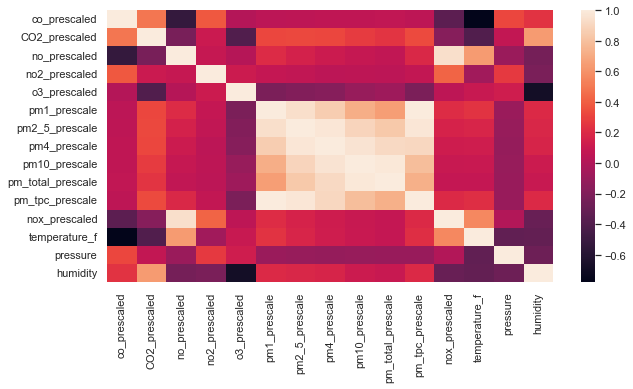

In [11]:
#Correlation heatmap for UIUC Sensor Data
sns.set(rc={'figure.figsize':(10,5)})
sns.heatmap(df3.corr())

<AxesSubplot:>

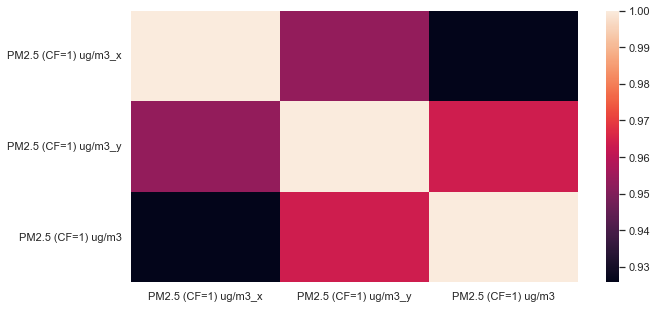

In [12]:
#Correlation heatmap for all Purple Air data
sns.heatmap(temp_dfnew.corr())

<AxesSubplot:>

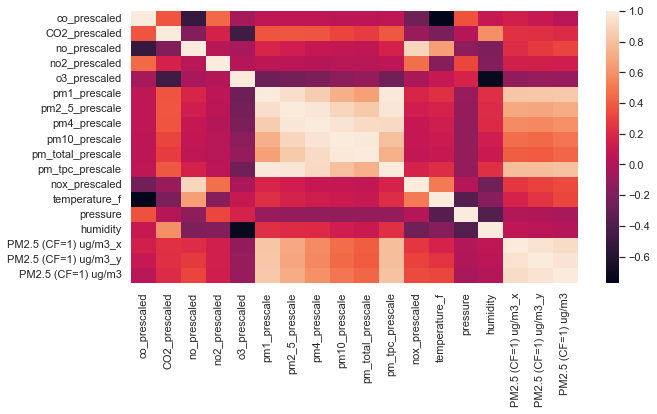

In [13]:
#Correlation heatmap for combined sensor data
sns.heatmap(final_df.corr())

The above heatmaps show the significant impact of each variable on every other variable in the data collected from the UIUC sensor as well as the Purple Air sensors. We see a significant correlation between Temperature and PM 2.5 values as indicated by the dark red colouring. We also see a strong correlation between Humidity and PM 2.5 values. This is what will be explored further in Hypothesis 3

<AxesSubplot:>

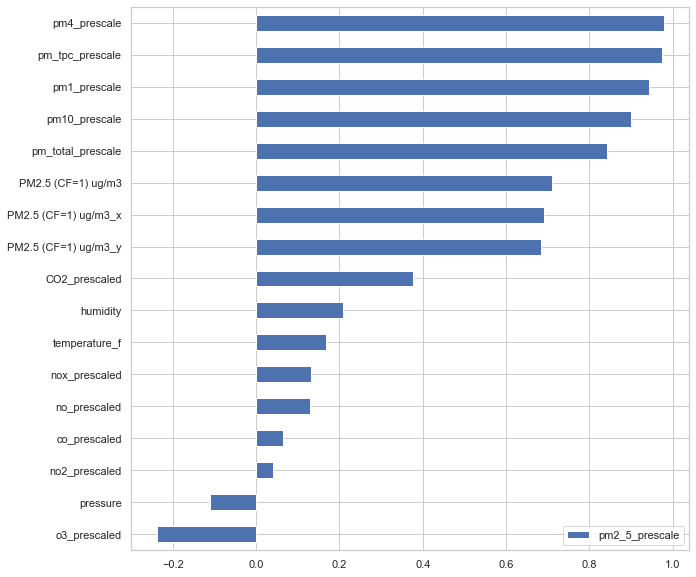

In [14]:
#Idea for this plot based on Binh Nguyen, Air Quality Analysis, GitHub repository:
#https://github.com/binh-bk/air-quality-analysis
a = final_df.corr()['pm2_5_prescale'].sort_values()
b = a.to_frame()
sns.set_style('whitegrid')
#Correlation of PM2.5 values from Purple air to other recorded variables
fig, ax = plt.subplots(figsize=(10,10))
b.drop('pm2_5_prescale').plot.barh(ax=ax)

<h8> The above bar graph shows a simpler representation of the correlations. </h8>

Text(0, 0.5, 'pm2_5_prescale')

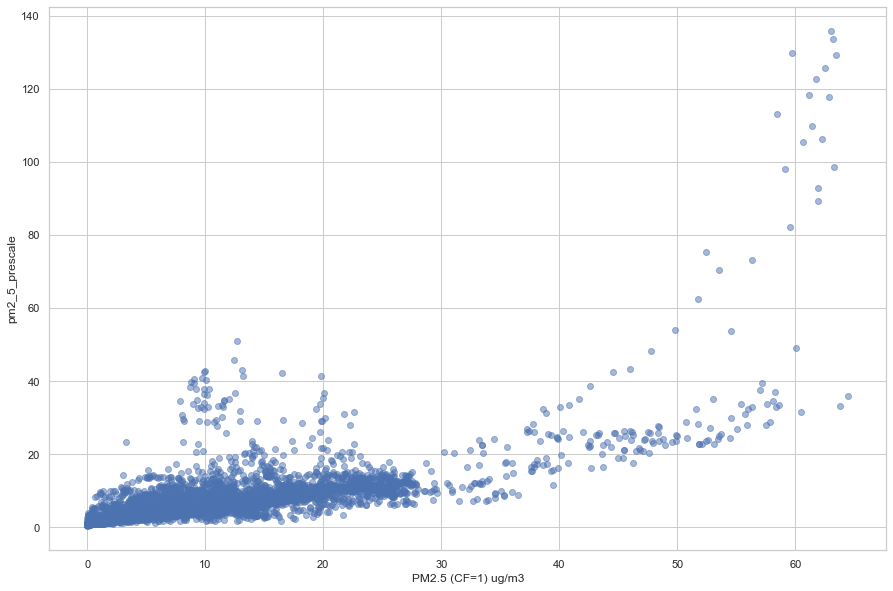

In [15]:
#Scatter plot showing correlation between purple air PC 2.5 values and UIUC sensor PM 2.5 values
plt.figure(figsize=(15,10))
plt.scatter(final_df['PM2.5 (CF=1) ug/m3'], final_df['pm2_5_prescale'], alpha = 0.5)
plt.xlabel("PM2.5 (CF=1) ug/m3")
plt.ylabel("pm2_5_prescale")


<h8> The above scatter plot shows the difference in measurement of PM2.5 values by the UIUC sensor and one of the Purple Air sensors. The slight deviation might be due to the difference in location of the two sensors.</h8>

array([<AxesSubplot:xlabel='new_date'>, <AxesSubplot:xlabel='new_date'>],
      dtype=object)

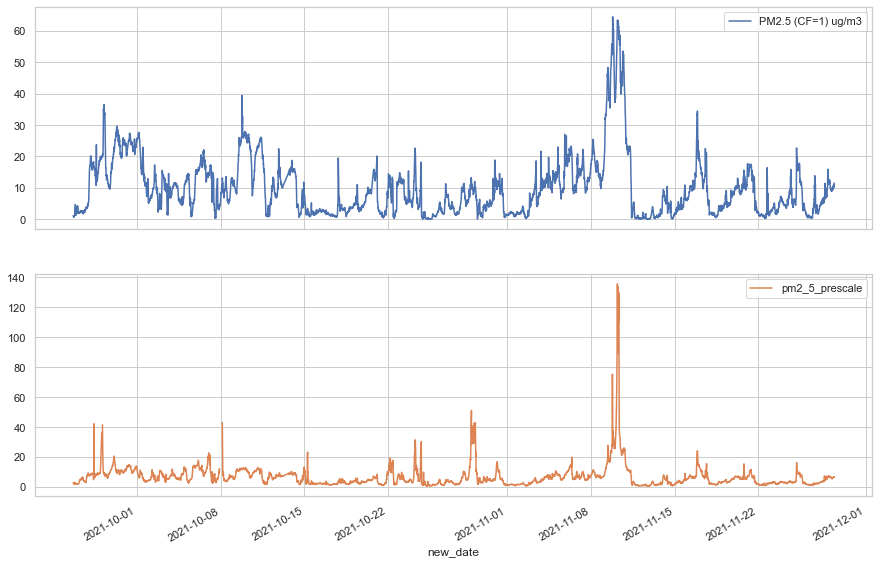

In [16]:
#Variation of PM 2.5 Values from Purple air and UIUC sensor over time
final_df[['PM2.5 (CF=1) ug/m3', 'pm2_5_prescale']].plot(subplots = True, figsize = (15,10), legend = True)

<h8> The above line graph shows the behaviour of PM2.5 from September 2021 to the 1st of December 2021. The trends are almost similiar for both sensors, indicating that both the sensors are almost equally accurate. </h8>

# HYPOTHESIS 3
<h8> Hypothesis 3 will reveal if PM 2.5 has any relation to meteorological factors namely, Temperature, Humidity and Windspeed.
We hypothesize that there is a very significant relationship between Temperature, Humidity and Windspeed to the presence of particulate matter in the air.
PM 2.5 will be higher around room temperature.
PM 2.5 will be greater from 70 to 90% humidity.
PM 2.5 will be more in number for winds ranging from 5m/s to 12m/s </h8>

<h3> Gathering Windspeed data from MERRA for Sep 30 </h3>

<h8> This data is obtained from the NASA MERRA-2 website and is stored in "netcdf4" format. </h8>

In [17]:
import xarray as xr

ds = xr.open_dataset('Data/MERRA2_401.inst1_2d_lfo_Nx.20200930.nc4')
ds1 = xr.open_dataset('Data/MERRA2_401.inst1_2d_lfo_Nx.20200929.nc4')
ds2 = xr.open_dataset('Data/MERRA2_401.inst1_2d_lfo_Nx.20200928.nc4')
df = ds.to_dataframe()

In [18]:
ds2

<xarray.Dataset>
Dimensions:   (lon: 576, lat: 361, time: 24)
Coordinates:
  * lon       (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * lat       (lat) float64 -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
  * time      (time) datetime64[ns] 2020-09-28 ... 2020-09-28T23:00:00
Data variables:
    HLML      (time, lat, lon) float32 ...
    PS        (time, lat, lon) float32 ...
    QLML      (time, lat, lon) float32 ...
    SPEEDLML  (time, lat, lon) float32 ...
    TLML      (time, lat, lon) float32 ...
Attributes: (12/30)
    History:                           Re-processed file generated: Tue Nov  ...
    Comment:                           GMAO filename: d5124_m2_jan10.inst1_2d...
    Filename:                          MERRA2_401.inst1_2d_lfo_Nx.20200928.nc4
    Conventions:                       CF-1
    Institution:                       NASA Global Modeling and Assimilation ...
    References:                        http://gmao.gsfc.nasa.gov
    ...                                ...
    Contact:                           http://gmao.gsfc.nasa.gov
    identifier_product_doi:            10.5067/RCMZA6TL70BG
    RangeBeginningDate:                2020-09-28
    RangeBeginningTime:                00:00:00.000000
    RangeEndingDate:                   2020-09-28
    RangeEndingTime:                   23:00:00.000000

<h8> The data is stored for each pair of coordinates for a particular time. The data is recorded for every hour over 24 hours. This data was recorded on September 30th and has information about the height of the surface layer, surface pressure, surface humidity and windspeed. </h8>

<h3> Filtering Wind Speed data to retain only the closest to the sensors </h3>

In [19]:
e = ds.loc[dict(lat="40.0", lon="-87.5")]
f = e.to_dataframe()
wind_df = f.reset_index()
wind_df['time'] = wind_df['time'].dt.time
wind_df.rename(columns={'time' : 'new_date'}, inplace = True)
wind_df = wind_df[['new_date','SPEEDLML']]
wind_df.set_index("new_date", inplace = True)
wind_df.head(5)

,SPEEDLML
new_date,
00:00:00,6.511623
01:00:00,6.950104
02:00:00,7.024870
03:00:00,7.052386
04:00:00,7.213359


In [20]:
e1 = ds1.loc[dict(lat="40.0", lon="-87.5")]
f1 = e1.to_dataframe()
wind_df1 = f1.reset_index()
wind_df1['time'] = wind_df1['time'].dt.time
wind_df1.rename(columns={'time' : 'new_date'}, inplace = True)
wind_df1 = wind_df1[['new_date','SPEEDLML']]
wind_df1.set_index("new_date", inplace = True)
wind_df1.head(5)

,SPEEDLML
new_date,
00:00:00,7.456863
01:00:00,7.223308
02:00:00,7.190830
03:00:00,7.244065
04:00:00,7.142029


In [21]:
e2 = ds2.loc[dict(lat="40.0", lon="-87.5")]
f2 = e2.to_dataframe()
wind_df2 = f2.reset_index()
wind_df2['time'] = wind_df2['time'].dt.time
wind_df2.rename(columns={'time' : 'new_date'}, inplace = True)
wind_df2 = wind_df2[['new_date','SPEEDLML']]
wind_df2.set_index("new_date", inplace = True)
wind_df2.head(5)

,SPEEDLML
new_date,
00:00:00,5.574650
01:00:00,5.541405
02:00:00,6.412581
03:00:00,6.736314
04:00:00,6.913863


In [22]:
df_clean = final_df.reset_index()
df_clean
filtered_df = df_clean.loc[(df_clean['new_date'] >= "2021-09-30 00:00:00") & (df_clean['new_date'] <= "2021-09-30 23:00:00")]
pd.options.mode.chained_assignment = None  # default='warn'
filtered_df['new_date'] = filtered_df['new_date'].dt.time
filtered_df.set_index("new_date", inplace = True)
filtered_df = filtered_df[filtered_df.index.isin(wind_df.index)]
filtered_df.head(5)

,co_prescaled,CO2_prescaled,no_prescaled,no2_prescaled,o3_prescaled,pm1_prescale,pm2_5_prescale,pm4_prescale,pm10_prescale,pm_total_prescale,pm_tpc_prescale,nox_prescaled,temperature_f,pressure,humidity,PM2.5 (CF=1) ug/m3_x,PM2.5 (CF=1) ug/m3_y,PM2.5 (CF=1) ug/m3
new_date,,,,,,,,,,,,,,,,,,
00:00:00,318.20,442.09,13.84,6.07,20.55,9.26,11.05,12.36,14.75,14.75,4.76,19.91,66.4,992.8,73.0,26.86500,28.931429,24.204286
01:00:00,322.74,446.72,14.29,5.50,19.19,9.84,11.85,13.45,18.41,18.44,5.09,19.79,65.5,992.1,74.3,27.23500,29.781429,24.200000
02:00:00,326.35,449.03,15.97,5.93,16.54,9.14,10.77,11.94,15.87,15.87,4.74,21.90,64.8,992.9,74.6,23.79500,26.144286,23.320000
03:00:00,341.77,447.64,14.54,6.56,15.08,10.16,12.03,13.24,14.86,14.86,5.21,21.10,66.0,992.9,76.0,23.33625,27.142857,20.875714
04:00:00,346.71,442.09,20.44,7.66,15.02,11.35,13.70,15.01,21.01,21.44,5.84,28.10,70.5,993.4,74.0,24.76250,27.467143,21.600000


In [23]:
filtered_df1 = df_clean.loc[(df_clean['new_date'] >= "2021-09-29 00:00:00") & (df_clean['new_date'] <= "2021-09-29 23:00:00")]
filtered_df1['new_date'] = filtered_df1['new_date'].dt.time
filtered_df1.set_index("new_date", inplace = True)
filtered_df1 = filtered_df1[filtered_df1.index.isin(wind_df.index)]
filtered_df1.head(5)

,co_prescaled,CO2_prescaled,no_prescaled,no2_prescaled,o3_prescaled,pm1_prescale,pm2_5_prescale,pm4_prescale,pm10_prescale,pm_total_prescale,pm_tpc_prescale,nox_prescaled,temperature_f,pressure,humidity,PM2.5 (CF=1) ug/m3_x,PM2.5 (CF=1) ug/m3_y,PM2.5 (CF=1) ug/m3
new_date,,,,,,,,,,,,,,,,,,
00:00:00,312.23,437.93,12.10,5.46,18.75,12.69,15.26,17.15,21.74,22.17,6.49,17.56,63.7,989.2,74.7,23.11875,26.580000,19.35500
01:00:00,318.55,444.87,9.97,5.30,17.22,15.02,18.18,20.62,22.04,22.07,7.66,15.27,62.6,989.5,76.5,24.57125,27.391429,20.71000
02:00:00,324.70,446.72,12.10,5.28,14.83,16.84,20.53,23.23,25.33,25.33,8.62,17.38,61.9,989.7,78.0,25.03375,28.351429,22.40500
03:00:00,340.98,444.87,13.27,7.62,13.17,14.64,17.56,19.71,23.13,23.53,7.44,20.89,63.9,989.8,79.0,26.08000,29.937143,23.28000
04:00:00,314.00,443.02,21.53,7.59,12.05,12.41,15.34,17.37,22.47,22.50,6.36,29.12,70.2,990.6,74.1,27.72000,31.221429,24.69625


In [24]:
filtered_df2 = df_clean.loc[(df_clean['new_date'] >= "2021-09-28 00:00:00") & (df_clean['new_date'] <= "2021-09-28 23:00:00")]
filtered_df2['new_date'] = filtered_df2['new_date'].dt.time
filtered_df2.set_index("new_date", inplace = True)
filtered_df2 = filtered_df2[filtered_df2.index.isin(wind_df.index)]
filtered_df2.head(5)

,co_prescaled,CO2_prescaled,no_prescaled,no2_prescaled,o3_prescaled,pm1_prescale,pm2_5_prescale,pm4_prescale,pm10_prescale,pm_total_prescale,pm_tpc_prescale,nox_prescaled,temperature_f,pressure,humidity,PM2.5 (CF=1) ug/m3_x,PM2.5 (CF=1) ug/m3_y,PM2.5 (CF=1) ug/m3
new_date,,,,,,,,,,,,,,,,,,
00:00:00,346.77,431.92,7.36,4.60,16.92,20.32,24.31,27.47,28.34,28.34,10.31,11.96,62.4,986.3,74.5,21.22250,24.16375,19.08500
01:00:00,335.76,433.77,10.12,4.86,14.35,22.86,33.77,44.46,48.46,48.49,12.24,14.98,61.2,986.3,77.0,21.78375,25.14500,19.71125
02:00:00,331.85,432.38,11.32,4.94,11.39,NaN,NaN,NaN,NaN,NaN,NaN,16.26,60.6,987.3,79.1,22.18750,24.87625,20.37250
03:00:00,335.87,428.22,10.06,6.37,9.70,18.92,29.90,39.90,40.54,40.54,10.34,16.43,61.3,987.9,80.5,21.96750,26.10875,20.14250
04:00:00,323.03,421.74,17.38,7.51,10.30,9.88,12.81,15.16,17.17,17.17,5.18,24.89,65.5,987.8,78.9,25.80875,27.99625,22.47750


In [25]:
windspeed_df = pd.merge(filtered_df, wind_df, on = 'new_date')
windspeed_df.head(5)

,co_prescaled,CO2_prescaled,no_prescaled,no2_prescaled,o3_prescaled,pm1_prescale,pm2_5_prescale,pm4_prescale,pm10_prescale,pm_total_prescale,pm_tpc_prescale,nox_prescaled,temperature_f,pressure,humidity,PM2.5 (CF=1) ug/m3_x,PM2.5 (CF=1) ug/m3_y,PM2.5 (CF=1) ug/m3,SPEEDLML
new_date,,,,,,,,,,,,,,,,,,,
00:00:00,318.20,442.09,13.84,6.07,20.55,9.26,11.05,12.36,14.75,14.75,4.76,19.91,66.4,992.8,73.0,26.86500,28.931429,24.204286,6.511623
01:00:00,322.74,446.72,14.29,5.50,19.19,9.84,11.85,13.45,18.41,18.44,5.09,19.79,65.5,992.1,74.3,27.23500,29.781429,24.200000,6.950104
02:00:00,326.35,449.03,15.97,5.93,16.54,9.14,10.77,11.94,15.87,15.87,4.74,21.90,64.8,992.9,74.6,23.79500,26.144286,23.320000,7.024870
03:00:00,341.77,447.64,14.54,6.56,15.08,10.16,12.03,13.24,14.86,14.86,5.21,21.10,66.0,992.9,76.0,23.33625,27.142857,20.875714,7.052386
04:00:00,346.71,442.09,20.44,7.66,15.02,11.35,13.70,15.01,21.01,21.44,5.84,28.10,70.5,993.4,74.0,24.76250,27.467143,21.600000,7.213359


In [26]:
windspeed_df1 = pd.merge(filtered_df1, wind_df1, on = 'new_date')
windspeed_df1.head(5)

,co_prescaled,CO2_prescaled,no_prescaled,no2_prescaled,o3_prescaled,pm1_prescale,pm2_5_prescale,pm4_prescale,pm10_prescale,pm_total_prescale,pm_tpc_prescale,nox_prescaled,temperature_f,pressure,humidity,PM2.5 (CF=1) ug/m3_x,PM2.5 (CF=1) ug/m3_y,PM2.5 (CF=1) ug/m3,SPEEDLML
new_date,,,,,,,,,,,,,,,,,,,
00:00:00,312.23,437.93,12.10,5.46,18.75,12.69,15.26,17.15,21.74,22.17,6.49,17.56,63.7,989.2,74.7,23.11875,26.580000,19.35500,7.456863
01:00:00,318.55,444.87,9.97,5.30,17.22,15.02,18.18,20.62,22.04,22.07,7.66,15.27,62.6,989.5,76.5,24.57125,27.391429,20.71000,7.223308
02:00:00,324.70,446.72,12.10,5.28,14.83,16.84,20.53,23.23,25.33,25.33,8.62,17.38,61.9,989.7,78.0,25.03375,28.351429,22.40500,7.190830
03:00:00,340.98,444.87,13.27,7.62,13.17,14.64,17.56,19.71,23.13,23.53,7.44,20.89,63.9,989.8,79.0,26.08000,29.937143,23.28000,7.244065
04:00:00,314.00,443.02,21.53,7.59,12.05,12.41,15.34,17.37,22.47,22.50,6.36,29.12,70.2,990.6,74.1,27.72000,31.221429,24.69625,7.142029


In [27]:
windspeed_df2 = pd.merge(filtered_df2, wind_df2, on = 'new_date')
windspeed_df2.head(5)

,co_prescaled,CO2_prescaled,no_prescaled,no2_prescaled,o3_prescaled,pm1_prescale,pm2_5_prescale,pm4_prescale,pm10_prescale,pm_total_prescale,pm_tpc_prescale,nox_prescaled,temperature_f,pressure,humidity,PM2.5 (CF=1) ug/m3_x,PM2.5 (CF=1) ug/m3_y,PM2.5 (CF=1) ug/m3,SPEEDLML
new_date,,,,,,,,,,,,,,,,,,,
00:00:00,346.77,431.92,7.36,4.60,16.92,20.32,24.31,27.47,28.34,28.34,10.31,11.96,62.4,986.3,74.5,21.22250,24.16375,19.08500,5.574650
01:00:00,335.76,433.77,10.12,4.86,14.35,22.86,33.77,44.46,48.46,48.49,12.24,14.98,61.2,986.3,77.0,21.78375,25.14500,19.71125,5.541405
02:00:00,331.85,432.38,11.32,4.94,11.39,NaN,NaN,NaN,NaN,NaN,NaN,16.26,60.6,987.3,79.1,22.18750,24.87625,20.37250,6.412581
03:00:00,335.87,428.22,10.06,6.37,9.70,18.92,29.90,39.90,40.54,40.54,10.34,16.43,61.3,987.9,80.5,21.96750,26.10875,20.14250,6.736314
04:00:00,323.03,421.74,17.38,7.51,10.30,9.88,12.81,15.16,17.17,17.17,5.18,24.89,65.5,987.8,78.9,25.80875,27.99625,22.47750,6.913863


In [28]:
wind_temp = pd.merge(wind_df, wind_df1, on = 'new_date')
wind_temp1 = pd.merge(wind_temp, wind_df2, on = 'new_date')
combined_wind = pd.merge(filtered_df, wind_temp1, on ='new_date')

In [29]:
combined_wind.head()

,co_prescaled,CO2_prescaled,no_prescaled,no2_prescaled,o3_prescaled,pm1_prescale,pm2_5_prescale,pm4_prescale,pm10_prescale,pm_total_prescale,...,nox_prescaled,temperature_f,pressure,humidity,PM2.5 (CF=1) ug/m3_x,PM2.5 (CF=1) ug/m3_y,PM2.5 (CF=1) ug/m3,SPEEDLML_x,SPEEDLML_y,SPEEDLML
new_date,,,,,,,,,,,,,,,,,,,,,
00:00:00,318.20,442.09,13.84,6.07,20.55,9.26,11.05,12.36,14.75,14.75,...,19.91,66.4,992.8,73.0,26.86500,28.931429,24.204286,6.511623,7.456863,5.574650
01:00:00,322.74,446.72,14.29,5.50,19.19,9.84,11.85,13.45,18.41,18.44,...,19.79,65.5,992.1,74.3,27.23500,29.781429,24.200000,6.950104,7.223308,5.541405
02:00:00,326.35,449.03,15.97,5.93,16.54,9.14,10.77,11.94,15.87,15.87,...,21.90,64.8,992.9,74.6,23.79500,26.144286,23.320000,7.024870,7.190830,6.412581
03:00:00,341.77,447.64,14.54,6.56,15.08,10.16,12.03,13.24,14.86,14.86,...,21.10,66.0,992.9,76.0,23.33625,27.142857,20.875714,7.052386,7.244065,6.736314
04:00:00,346.71,442.09,20.44,7.66,15.02,11.35,13.70,15.01,21.01,21.44,...,28.10,70.5,993.4,74.0,24.76250,27.467143,21.600000,7.213359,7.142029,6.913863


<AxesSubplot:>

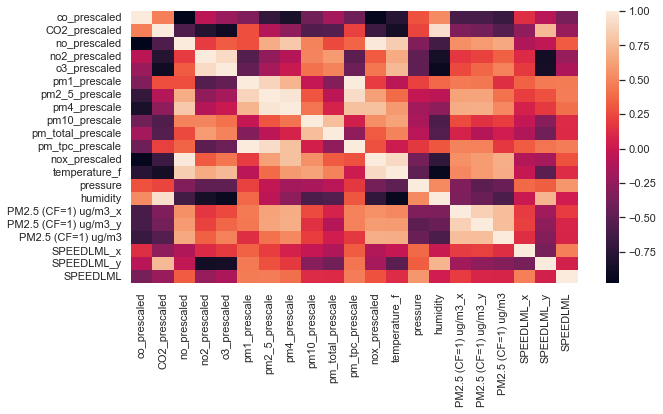

In [30]:
#Correlation between windspeeds and PM2.5 for three different days
sns.set(rc={'figure.figsize':(10,5)})
sns.heatmap(combined_wind.corr())

<h8> The above heatmap shows the correlation between windspeed and PM 2.5 on the various days that have been considered. There is a strong positive correlation around 0.5 between them, which indicates that as windspeed increases  the presence of particulate matter over a particular area might increase. </h8>

<h3> PM 2.5 vs Temperature </h3>

Text(0, 0.5, 'PC 2.5')

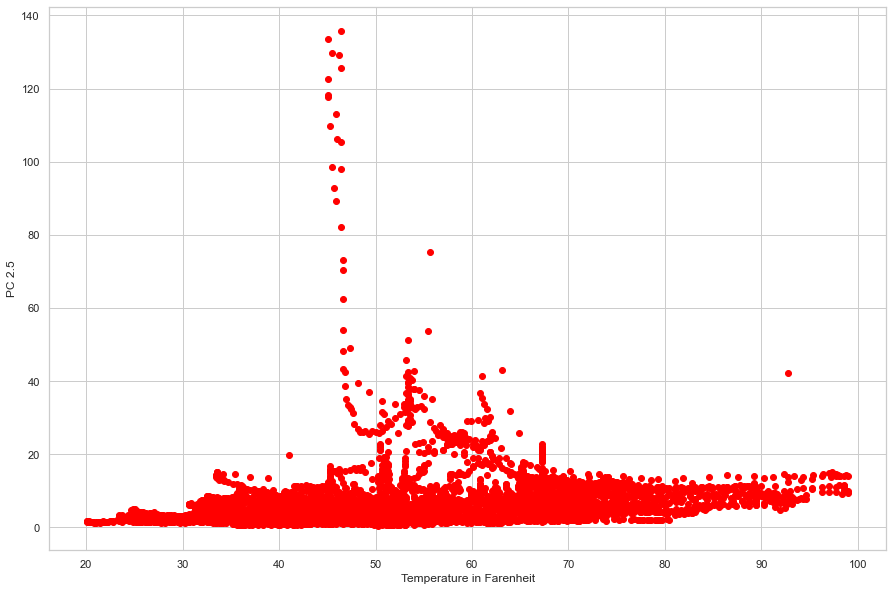

In [31]:
#Test plot showing variation of PC 2.5 with Temperature
sns.set_style('whitegrid')
plt.figure(figsize=(15,10))
plt.scatter(final_df['temperature_f'], final_df['pm2_5_prescale'], c='red')
plt.xlabel('Temperature in Farenheit')
plt.ylabel('PC 2.5')

<h8> The above scatter plot shows that the amount of particulate matter is very high for temperatures between 40 F to 70 F. This is as expected as there is more activity that causes pollution for this temperature, than for lower or higher temperatures. </h8>

[Text(0.5, 0, 'Temperature in Farenheit')]

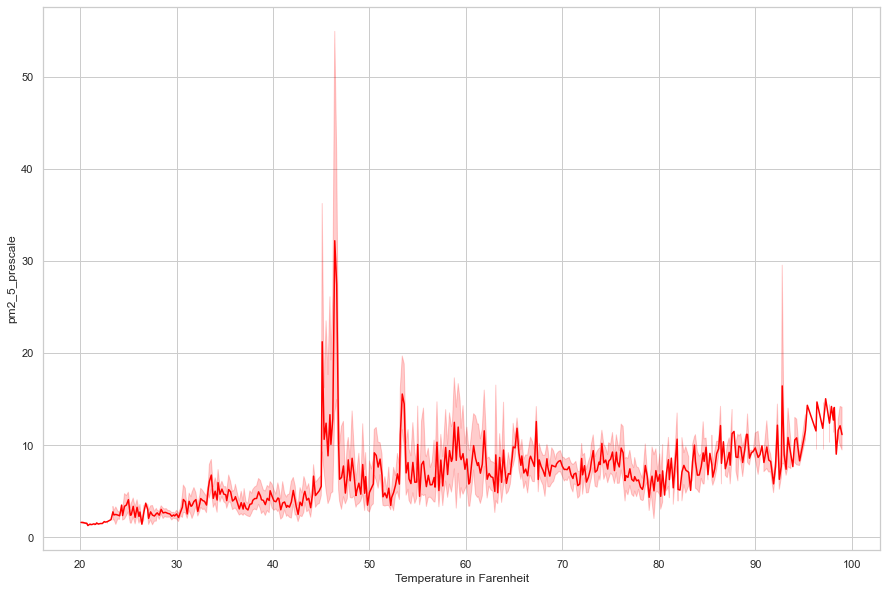

In [32]:
temperature_df = final_df.reset_index()
temperature_df = temperature_df[['new_date','pm2_5_prescale', 'temperature_f']]
sns.set(rc={'figure.figsize':(15,10)})
sns.set_style("whitegrid")
m=sns.lineplot(data = temperature_df, x="temperature_f", y="pm2_5_prescale", color="red")
m.set(xlabel='Temperature in Farenheit')


<h8> The above line plot shows that the amount of particulate matter peaks for temperatures between 40 F to 70 F. This is as expected as there is more activity that causes pollution for this temperature, than for lower or higher temperatures. </h8>

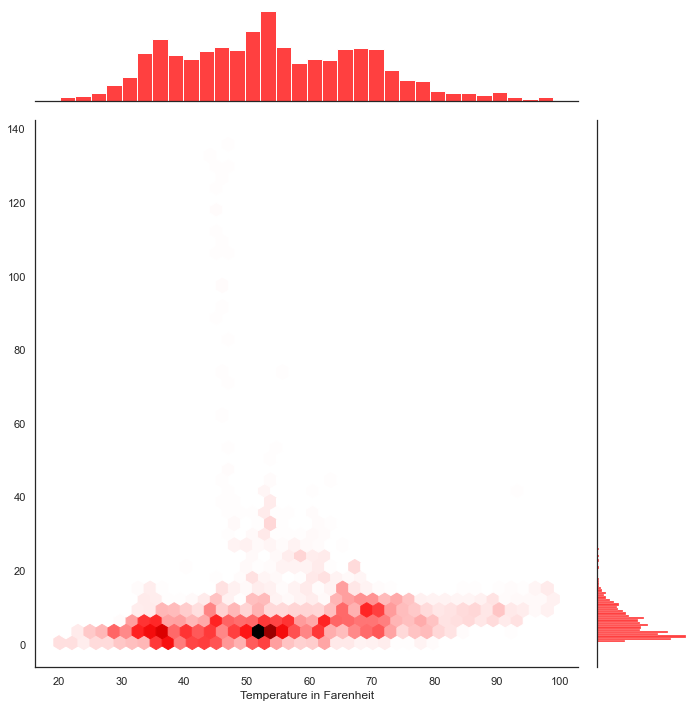

In [33]:
sns.set_style("white")
m1 = sns.jointplot(x = "temperature_f", y="pm2_5_prescale", data=temperature_df, kind="hex", color='red', height=10)
m1.set_axis_labels('Temperature in Farenheit')

<h8> The above hex density plot was generated to better understand the distribution of measurements. As there is a lot of data the scatter plot is a bit over crowded, the density plot categorises the data by temperature intervals. Darker the hexagon, greater is the density of recordings in that region. We can see that there have been more recordings around 50 F and 60 F. This was the most common temperature during the day for the months under consideration. It also shows that the average amount of particulate matter is around 0 to 10 ug/m3. </h8>

<h3> PM 2.5 vs Humidity </h3>

Text(0, 0.5, 'PC 2.5')

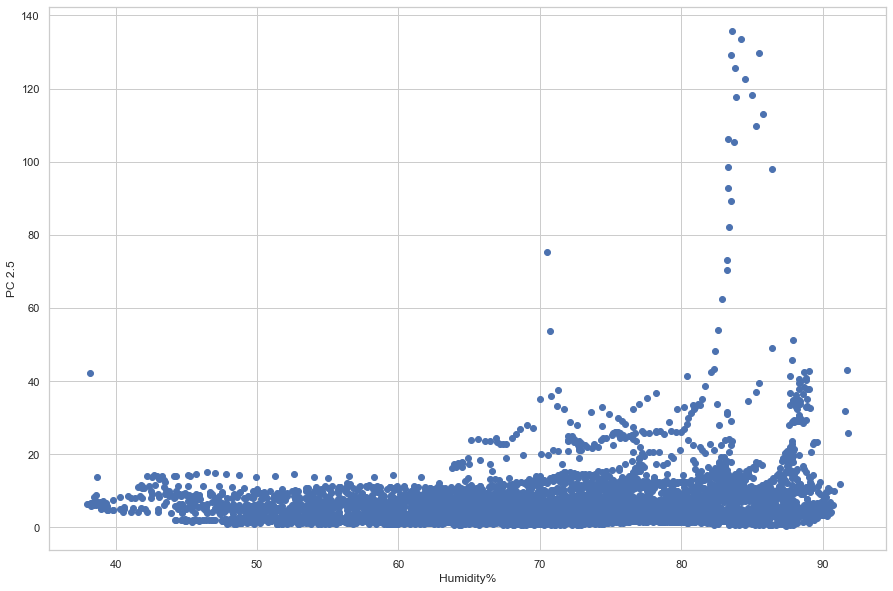

In [34]:
#Scatter plot showing variation of PC2.5 with Humidity
sns.set_style("whitegrid")
plt.figure(figsize=(15,10))
plt.scatter(final_df['humidity'], final_df['pm2_5_prescale'])
plt.xlabel('Humidity%')
plt.ylabel('PC 2.5')

<h8> The above scatter plot shows that the amount of particulate matter is very high for humidity between 70 to 90%. This is as expected as this is the average and most common humidity value in Illinois. </h8>

[Text(0.5, 0, 'Humidity%')]

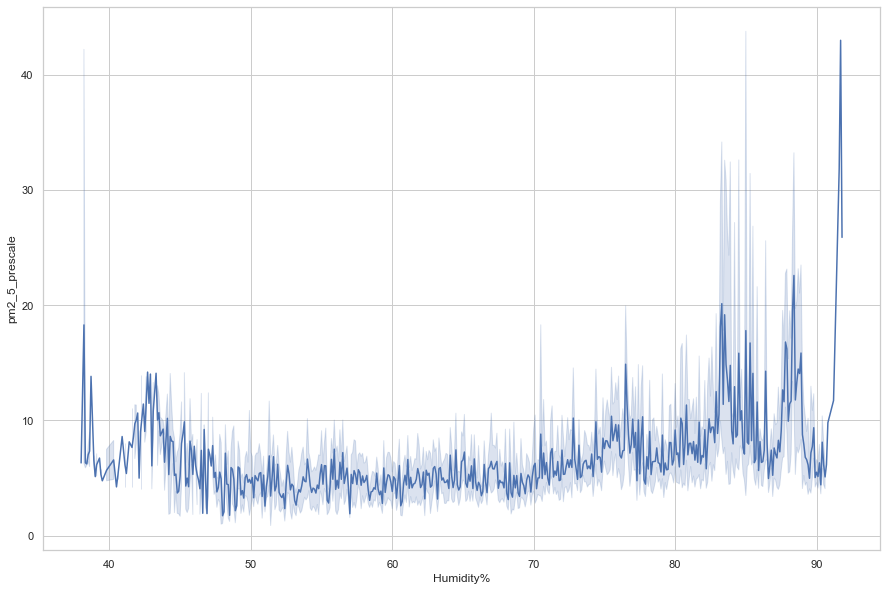

In [35]:
humidity_df = final_df.reset_index()
humidity_df = humidity_df[['new_date','pm2_5_prescale', 'humidity']]
n = sns.lineplot(data = humidity_df, x="humidity", y="pm2_5_prescale")
n.set(xlabel="Humidity%")

<h8> The above line plot shows that the amount of particulate matter is very high for humidity between 70 to 90%. This is as expected as this is the average and most common humidity value in Illinois. </h8>

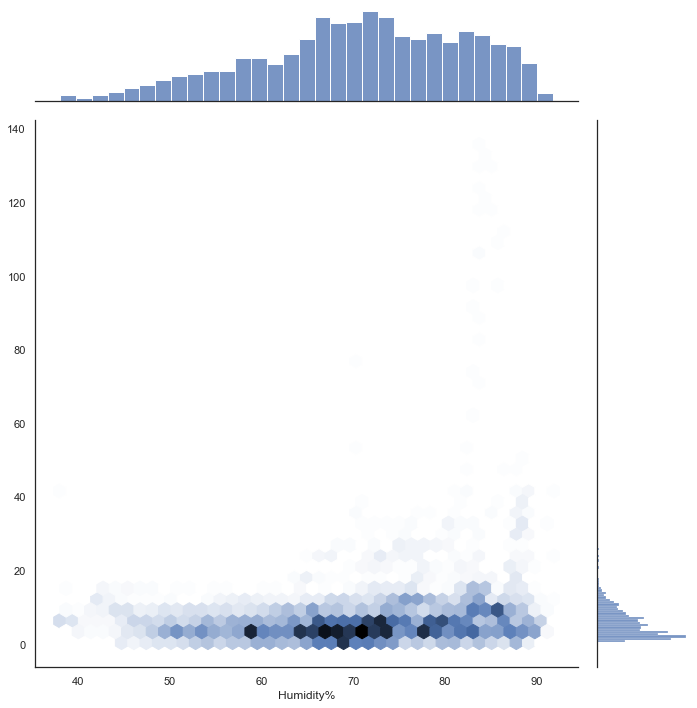

In [36]:
sns.set_style("white")
n1 = sns.jointplot(x = "humidity", y="pm2_5_prescale", data=humidity_df, kind="hex", height=10)
n1.set_axis_labels('Humidity%')

<h8> The above hex density plot was generated to better understand the distribution of measurements. As there is a lot of data the scatter plot is a bit over crowded, the density plot categorises the data by humidity intervals. Darker the hexagon, greater is the density of recordings in that region. We can see that there have been more recordings around 60 to 80% range. This was the average humidity in Illinois. It also seconds the results shown by the temperature density plot, that the average and most common amount of particulate matter is around 0 to 10 ug/m3. </h8>

<h3> PM 2.5 vs Wind Speed </h3>

[Text(0.5, 48.5, 'Windspeed in m/s')]

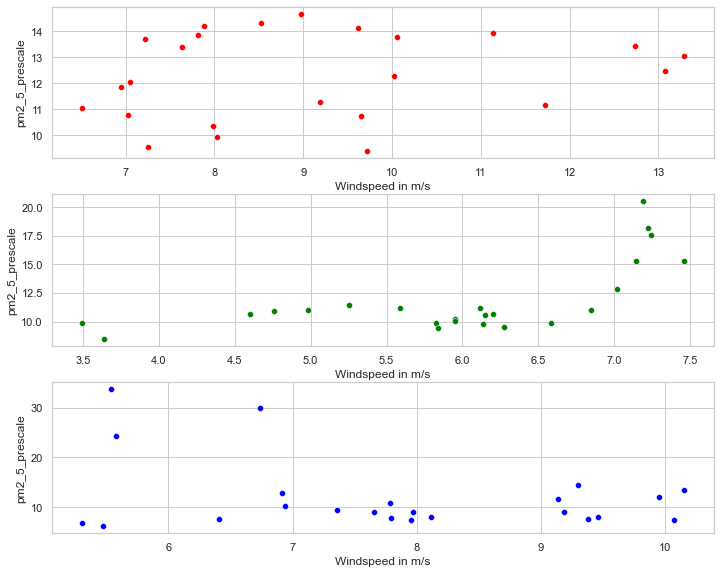

In [37]:
sns.set_style("whitegrid")
figs, axs = plt.subplots(3, figsize=(10,8))
figs.tight_layout()
x = sns.scatterplot(data = windspeed_df, x="SPEEDLML", y="pm2_5_prescale", color = 'red', ax = axs[0])
y = sns.scatterplot(data = windspeed_df1, x="SPEEDLML", y="pm2_5_prescale", color = 'green', ax = axs[1])
z = sns.scatterplot(data = windspeed_df2, x="SPEEDLML", y="pm2_5_prescale", color = 'blue', ax = axs[2])
x.set(xlabel='Windspeed in m/s')
y.set(xlabel='Windspeed in m/s')
z.set(xlabel='Windspeed in m/s')

<h8> The above scatter plot shows that the amount of particulate matter rises for windspeeds from 6 m/s to 10m/s but this is not very clear. </h8>

[Text(0.5, 48.5, 'Windspeed in m/s')]

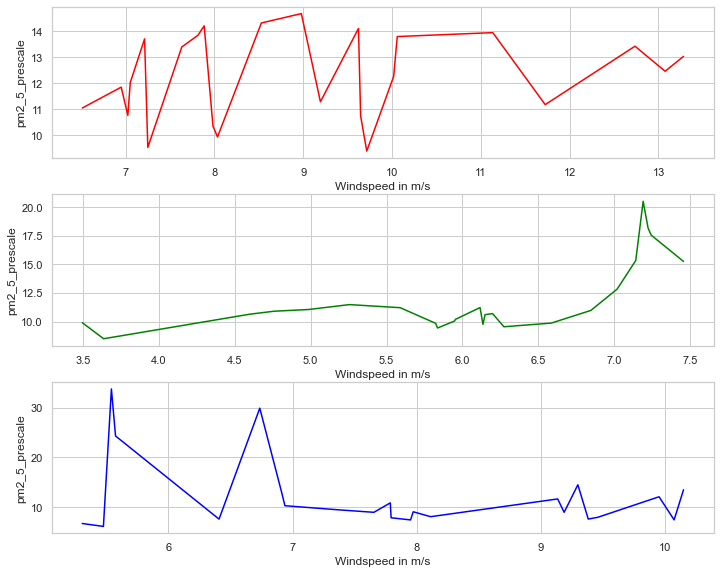

In [38]:
figs, axs = plt.subplots(3, figsize=(10,8))
figs.tight_layout()
sns.set_style("whitegrid")
p = sns.lineplot(data = windspeed_df, x="SPEEDLML", y="pm2_5_prescale", color = 'red', ax = axs[0])
q = sns.lineplot(data = windspeed_df1, x="SPEEDLML", y="pm2_5_prescale", color = 'green', ax = axs[1])
r = sns.lineplot(data = windspeed_df2, x="SPEEDLML", y="pm2_5_prescale", color = 'blue', ax = axs[2])
p.set(xlabel='Windspeed in m/s')
q.set(xlabel='Windspeed in m/s')
r.set(xlabel='Windspeed in m/s')

<h8> The above line plots shows that the amount of particulate matter peaks for windspeeds between 6 m/s and 10 m/s </h8>

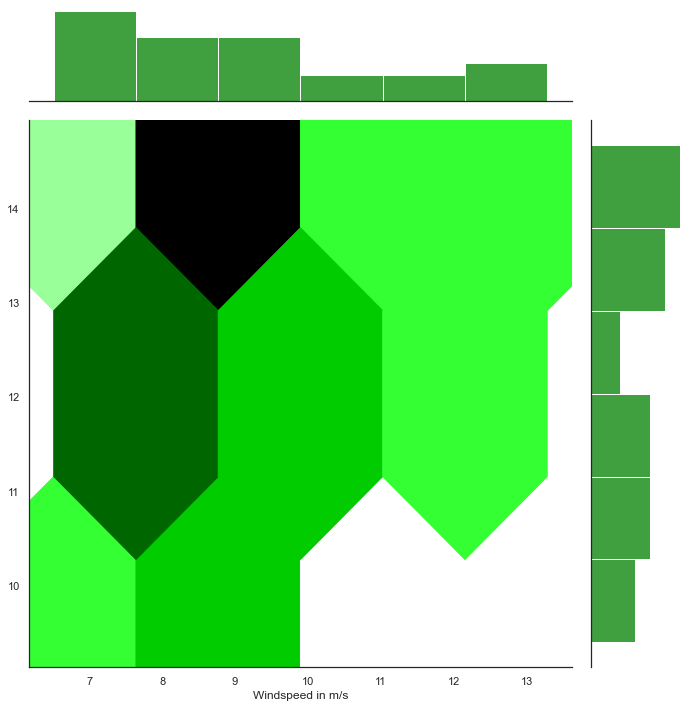

In [39]:
sns.set_style("white")
x1 = sns.jointplot(x="SPEEDLML", y="pm2_5_prescale", data=windspeed_df, kind='hex', color='green', height=10)
x1.set_axis_labels('Windspeed in m/s')

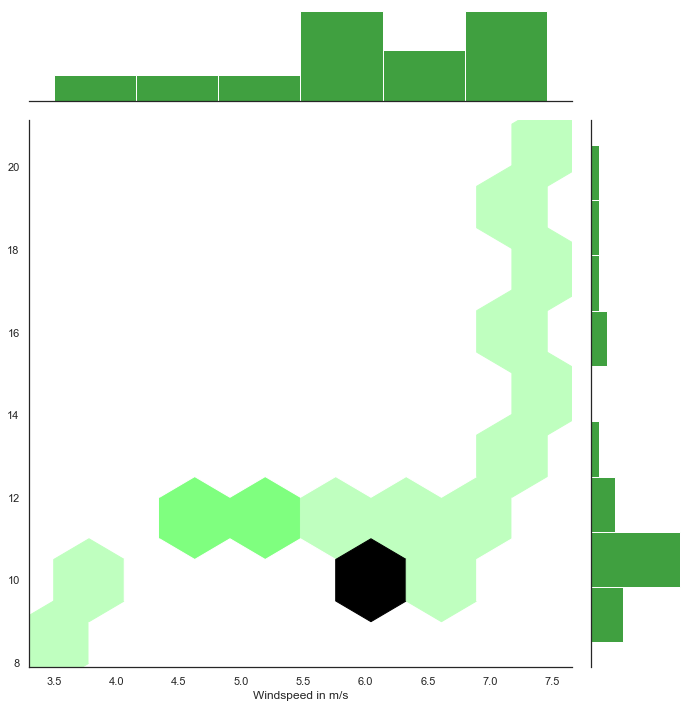

In [40]:
sns.set_style("white")
y1 = sns.jointplot(x="SPEEDLML", y="pm2_5_prescale", data=windspeed_df1, kind='hex', color='green', height=10)
y1.set_axis_labels('Windspeed in m/s')

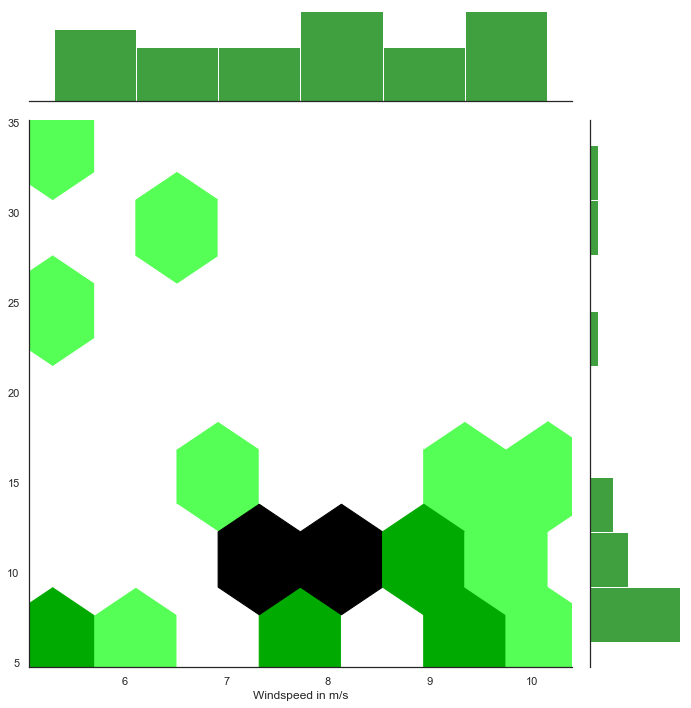

In [41]:
sns.set_style("white")
z1 = sns.jointplot(x="SPEEDLML", y="pm2_5_prescale", data=windspeed_df2, kind='hex', color='green', height=10)
z1.set_axis_labels('Windspeed in m/s')

<h8> The above density plots show that the most common windspeeds for the three days in Sepetember were between 6 and 10 m/s. It also shows that the most common amount of PM2.5 present in the air was between 10 and 14 ug/m3. </h8>

# DISCUSSIONS AND CONCLUSIONS

<h8> The above visualisations give us a better understanding of the variation of the amount of particulate matter in the atmosphere with changes in various meteorological factors.
Our hypothesis was split into three seperate studies, one with temperature, one with humidity and one with windspeed. We observe that the behaviour of the PM2.5 measurements is as hypothesized. </h8>



<h3> Temperature and PM 2.5 </h3>

<h8> The values of PM 2.5 are higher for values around room temperature. This is as expected as the activities that generate particulate matter are more common during the day when the temperatures are around room temperature. Also, there is higher activity when the temperature is pleasant. The trends also show that there is more particulate matter in the air during peak hours, during which a majority of vehicles ply and factories are working. Lower temperatures are expected during night time and early hours in the morning during which there is not much activity which explains the lower values of particulate matter. </h8>

<h3> Humidity and PM 2.5 </h3>


<h8> The hypothesis holds true that higher amount of particulate matter is present in the air when the humidity is between 70 to 90%. This is because the average humidity in Illinois is around this value for the months that have been taken into consideration for this study. The density of recordings are also highest in this range because this is the most commonly occuring value. As humidity increases, the moisture in air adheres to the particulate matter uptill a certain point, beyond this a phenomenon called dry disposition occurs. Dry disposition is the fall of particulate matter from air as it gets extremely heavy to remain suspended. The humidity range of 70 to 90% is the ideal range for particulate matter concentration to increase until dry disposition occurs. </h8>

<h3> Windspeed and PM 2.5 </h3>

<h8> As hyopthesized we see that the amount of PM 2.5 matter in air is higher when the windspeed is between 6m/s and 12 m/s which is classified as moderate to heavy breeze. There are huge crests and troughs in the plots between this speed as well, this can be due to the blowing away of the particulate matter from the location of the sensor when the recording is done. The data is taken over three days where the windspeed was very similar and there were no exceptional changes. The scope of this hypothesis is limited as the data under consideration is not sufficient to make a convincing argument. Yet, there are clear trends and indications that the amount of particulate matter is higher when there is a breeze blowing as matter is carried over. It is also not too farfetched to conclude that particulate matter is also high when the windspeed is low as they settle in the air and are not displaced but this cannot be directly derived from our study. </h8>

# Scalability

<h8> The research conducted by our team has been restricted to one particular location and only for a small time period of three months. Despite this, the conclusions drawn from our research are extremely informative and useful in indicating the behaviour of particulate matter with various factors. There is huge scope for expanding this reasearch, larger amounts of data can be procured and studied in the same manner. Different locations on Earth can be explored and the air quality can be predicted based on temperature, humidity and wind speed. This study is valuable in controlling and preventing an increase in air pollution. </h8>